# **Time Series Gold Forcasting (1968-2025)**

## **Data Understanding**

### Basic Information

* Total rows: `14,496`
* Columns: 2

  1. `Date` → datetime (`1968-03-22` to `2025`)
  2. `gold_price_usd` → float (gold price in USD)

---

### Date Column

* Type: `datetime64[ns]`
* No missing values
* Represents daily gold price records from 1968 onward.

---

### Gold Price Column (`gold_price_usd`)

* Type: `float64`
* No missing values
* Min: 34.95 USD
* Max: 3,983.40 USD
* Mean: 711.86 USD
* Median: 394.58 USD
* 25% Quantile: 299.60 USD
* 75% Quantile: 1,202.31 USD

---

### Insights

* Data is complete (no nulls).
* Price range shows a large increase over time.
* Distribution is likely right-skewed (mean > median), indicating more recent higher prices.
* This dataset is suitable for time series analysis (trend, forecasting, volatility, etc.).

### Download Data from Yahoo Finance (2000 - 2025)

In [1]:
# import os
# import yfinance as yf

# # Define the ticker symbol
# ticker_symbol = "GC=F"

# # Create a Ticker object
# ticker = yf.Ticker(ticker_symbol)

# # Fetch historical market data
# historical_data = ticker.history(period="max")
# print("Historical Data:")
# print(historical_data)

# # Fetch basic financials
# financials = ticker.financials
# print("\nFinancials:")
# print(financials)

# # Fetch stock actions like dividends and splits
# actions = ticker.actions
# print("\nStock Actions:")
# print(actions)

# # Save historical data to a CSV file
# os.makedirs("data", exist_ok=True)
# historical_data.to_excel("data/gold_2000-2025.xlsx")

### Data Merging

In [2]:
# import pandas as pd
# df_gold_1968_2024 = pd.read_excel('data/Nilai Emas dalam USD.xlsx', parse_dates=['Date'])
# df_gold_2000_2025 = pd.read_excel('data/gold_2000-2025.xlsx', parse_dates=['Date'])

In [3]:
# # Step 1: Normalize the Date columns (remove timezone info and ensure consistent format)
# import pandas as pd

# # Create copies of the datasets to avoid modifying originals
# df1 = df_gold_1968_2024.copy()
# df2 = df_gold_2000_2025.copy()

# # Normalize dates (remove timezone information)
# df1['Date'] = pd.to_datetime(df1['Date']).dt.date
# # For df2, first convert to UTC then to date to handle timezone
# df2['Date'] = pd.to_datetime(df2['Date'], utc=True).dt.date

# # Rename columns to English standard names
# df1_normalized = df1.rename(columns={'Price_USD_Gold': 'gold_price_usd'})
# df2_normalized = df2[['Date', 'Close']].rename(columns={'Close': 'gold_price_usd'})

# # Step 2: Merge datasets with priority to df_gold_1968_2024
# # First, find overlapping dates
# df1_dates = set(df1_normalized['Date'])
# df2_dates = set(df2_normalized['Date'])
# overlapping_dates = df1_dates.intersection(df2_dates)

# # Remove overlapping dates from df2 (since df1 takes priority)
# df2_filtered = df2_normalized[~df2_normalized['Date'].isin(overlapping_dates)]

# # Combine the datasets
# merged_gold_data = pd.concat([df1_normalized, df2_filtered], ignore_index=True)

# # Sort by date
# merged_gold_data = merged_gold_data.sort_values('Date').reset_index(drop=True)

# # Convert Date back to datetime for easier manipulation
# merged_gold_data['Date'] = pd.to_datetime(merged_gold_data['Date'])

# # Save the merged dataset
# merged_gold_data.to_excel('data/gold_1968-2025.xlsx', index=False)

### Load Data from Drive

In [4]:
import os
import gdown
import shutil

# === Konfigurasi ===
file_id = "1_KK20uJsdKDG5XbXZFCxK-UvKUWZho9K"   # ID dari URL Google Drive
download_url = f"https://drive.google.com/uc?id={file_id}"
file_name = "gold_1968-2025.xlsx"
data_dir = "data"
file_path = os.path.join(data_dir, file_name)
temp_file = file_name  # file sementara setelah download

# === 1. Cek apakah file sudah ada ===
if os.path.exists(file_path):
    print(f"✅ File '{file_path}' sudah ada. Lewati proses download.")
else:
    # === 2. Buat direktori data jika belum ada ===
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        print(f"📁 Folder '{data_dir}' dibuat.")

    # === 3. Download file ===
    print(f"⬇️ Mengunduh file dari Google Drive...")
    gdown.download(download_url, temp_file, quiet=False)

    # === 4. Pindahkan file ke folder data ===
    shutil.move(temp_file, file_path)
    print(f"📦 File dipindahkan ke: {file_path}")

print("✅ Selesai.")

✅ File 'data\gold_1968-2025.xlsx' sudah ada. Lewati proses download.
✅ Selesai.


## **Exploratory Data Analysis (EDA)**

### Import Libraries & Load Data

In [5]:
import os
import ta
import time
import pickle
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display settings
plt.style.use('seaborn-v0_8')
sns.set_palette("deep")
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [6]:
# Load dataset
file_path = 'data/gold_1968-2025.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')

In [7]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14496 entries, 0 to 14495
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            14496 non-null  datetime64[ns]
 1   gold_price_usd  14496 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 226.6 KB


### Basic Descriptive Statistics

In [8]:
# Descriptive stats
print("\nDescriptive Statistics:")
print(df.describe())

# Date range
print(f"\nDate range: {df['Date'].min().date()} to {df['Date'].max().date()}")


Descriptive Statistics:
                                Date  gold_price_usd
count                          14496       14,496.00
mean   1997-09-25 11:53:38.543046400          711.86
min              1968-03-22 00:00:00           34.95
25%              1983-11-01 18:00:00          299.60
50%              1997-11-17 12:00:00          394.58
75%              2011-10-19 06:00:00        1,202.31
max              2025-10-07 00:00:00        3,983.40
std                              NaN          652.84

Date range: 1968-03-22 to 2025-10-07


### Gold Price Trend Over Time

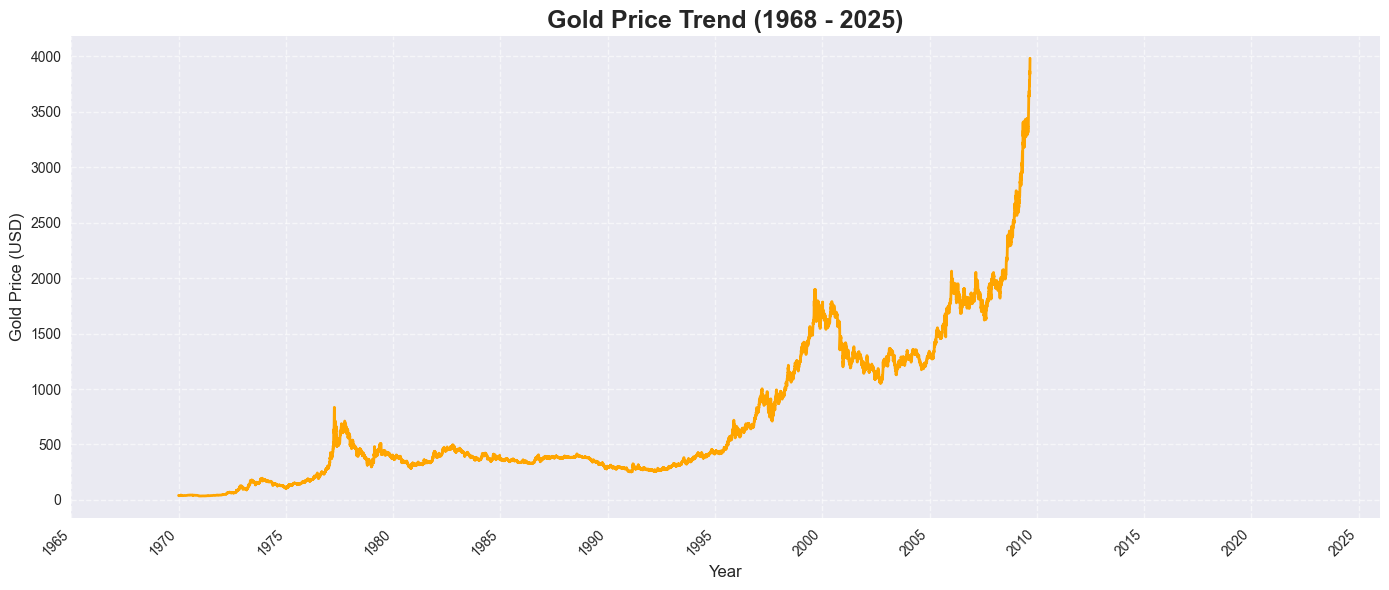

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['gold_price_usd'], color='orange', linewidth=2)
plt.title('Gold Price Trend (1968 - 2025)', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Gold Price (USD)', fontsize=12)

# Show every 5 years on x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))   # every 5 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(pd.to_datetime('1965-01-01'), pd.to_datetime('2025-12-31'))  # range
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Monthly Price

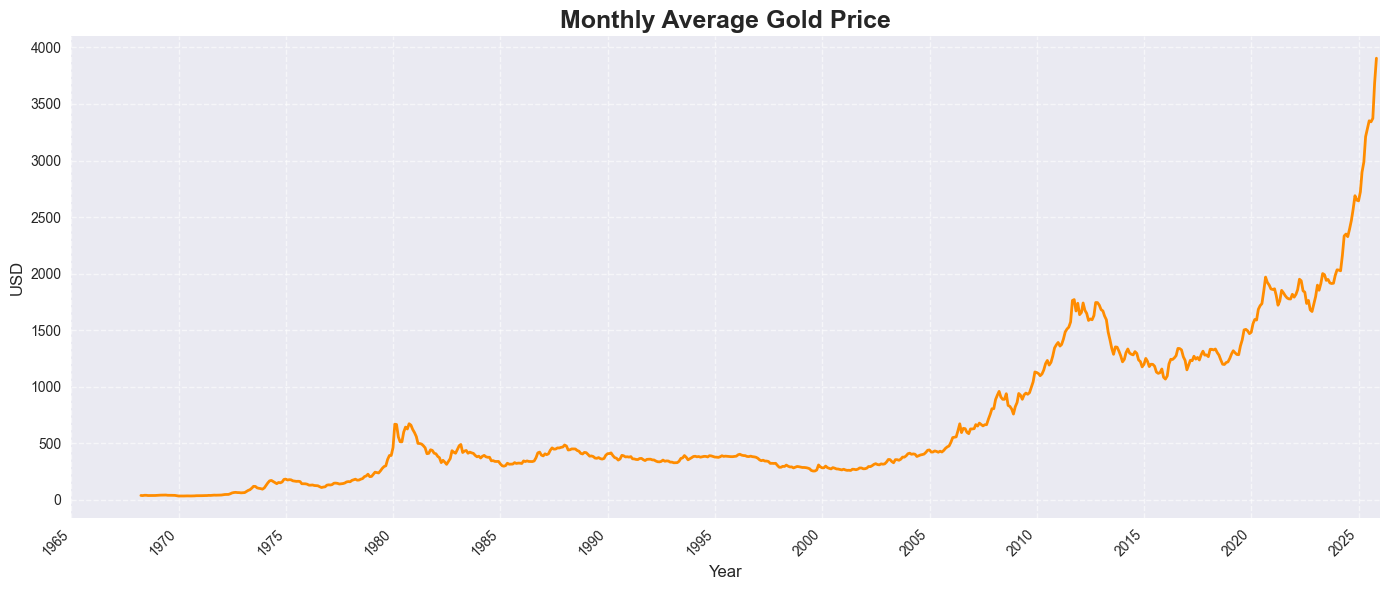

In [10]:
# Convert Date to index for resampling
df = df.set_index('Date')

monthly = df['gold_price_usd'].resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly.index, monthly, color='darkorange', linewidth=2)
plt.title('Monthly Average Gold Price', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('USD', fontsize=12)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))   # every 5 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(pd.to_datetime('1965-01-01'), pd.to_datetime('2025-12-31'))
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Yearly Gold Price

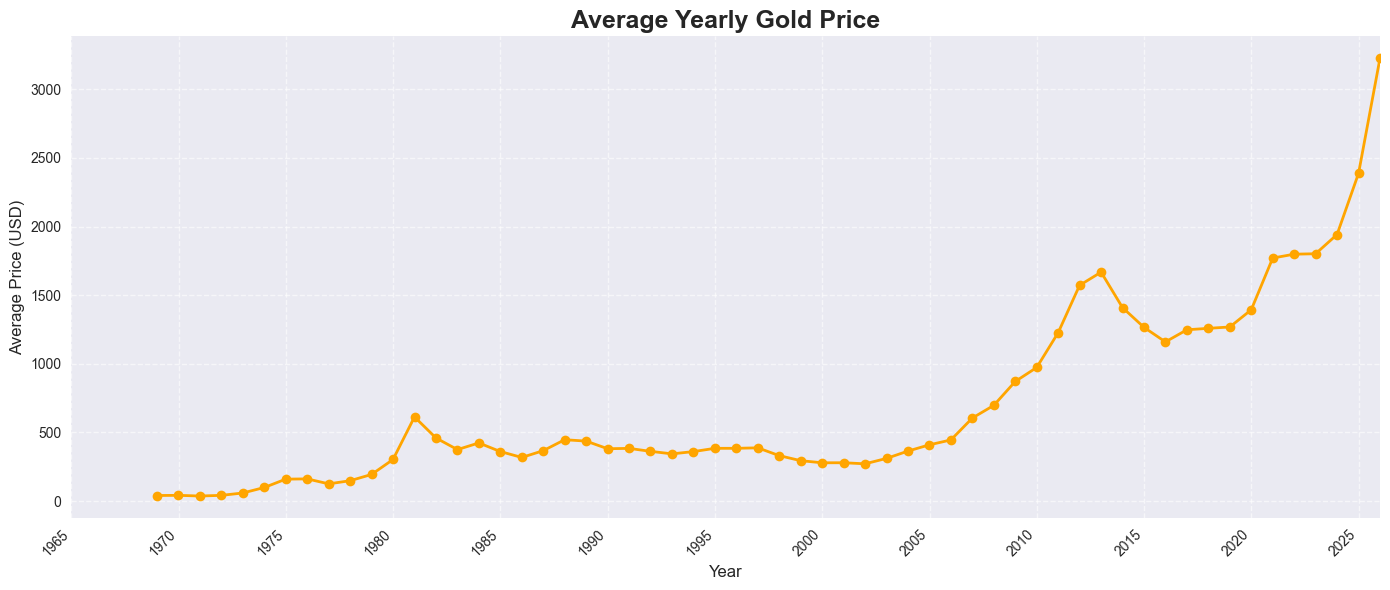

In [11]:
yearly_avg = df['gold_price_usd'].resample('Y').mean()

plt.figure(figsize=(14, 6))
plt.plot(yearly_avg.index, yearly_avg, color='orange', marker='o', linewidth=2)
plt.title('Average Yearly Gold Price', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Price (USD)', fontsize=12)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))   # every 5 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(pd.to_datetime('1965-01-01'), pd.to_datetime('2025-12-31'))
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Daily Change

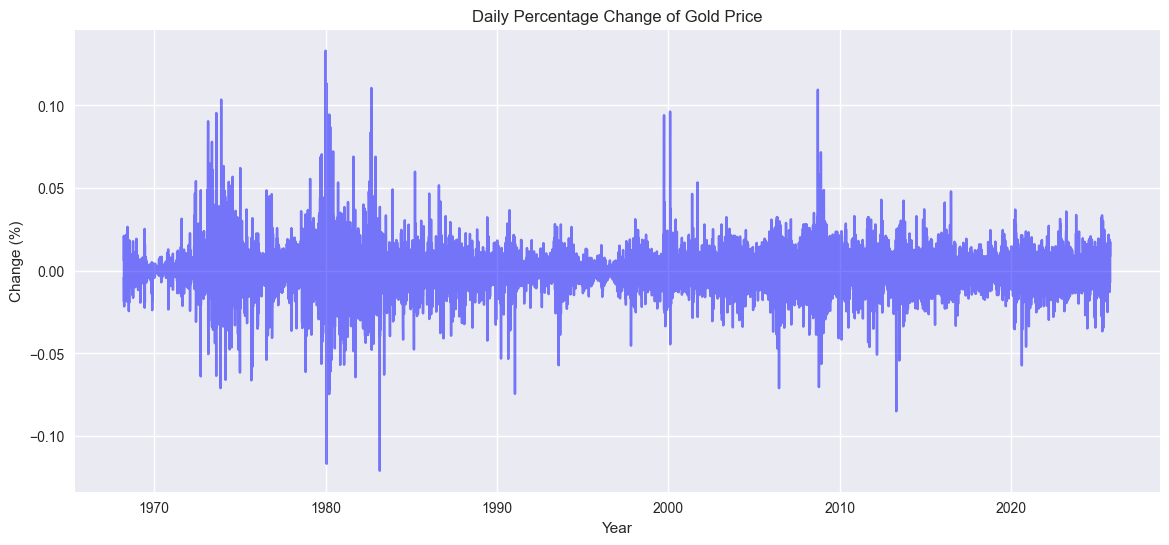

count   14,495.00
mean         0.00
std          0.01
min         -0.12
25%         -0.00
50%          0.00
75%          0.01
max          0.13
Name: Daily_Change, dtype: float64


In [12]:
# Calculate daily return
df['Daily_Change'] = df['gold_price_usd'].pct_change()

plt.figure(figsize=(14,6))
plt.plot(df.index, df['Daily_Change'], color='blue', alpha=0.5)
plt.title('Daily Percentage Change of Gold Price')
plt.xlabel('Year')
plt.ylabel('Change (%)')
plt.grid(True)
plt.show()

# Summary of daily change
print(df['Daily_Change'].describe())

## **Feature Engineering**

### Technical Indicators

In [13]:
print("🔧 Memulai proses Feature Engineering...")

# Salin dataframe utama
df_feat = df.copy()

# Moving Averages
df_feat['SMA_7'] = df_feat['gold_price_usd'].rolling(window=7).mean()
df_feat['SMA_30'] = df_feat['gold_price_usd'].rolling(window=30).mean()
df_feat['SMA_90'] = df_feat['gold_price_usd'].rolling(window=90).mean()
df_feat['EMA_12'] = df_feat['gold_price_usd'].ewm(span=12, adjust=False).mean()
df_feat['EMA_26'] = df_feat['gold_price_usd'].ewm(span=26, adjust=False).mean()

# RSI (Relative Strength Index)
df_feat['RSI_14'] = ta.momentum.RSIIndicator(df_feat['gold_price_usd'], window=14).rsi()

# MACD (Moving Average Convergence Divergence)
macd = ta.trend.MACD(df_feat['gold_price_usd'])
df_feat['MACD'] = macd.macd()
df_feat['MACD_signal'] = macd.macd_signal()
df_feat['MACD_diff'] = macd.macd_diff()

# Bollinger Bands
boll = ta.volatility.BollingerBands(df_feat['gold_price_usd'], window=20, window_dev=2)
df_feat['Bollinger_High'] = boll.bollinger_hband()
df_feat['Bollinger_Low'] = boll.bollinger_lband()
df_feat['Bollinger_Width'] = (df_feat['Bollinger_High'] - df_feat['Bollinger_Low']) / df_feat['gold_price_usd']

🔧 Memulai proses Feature Engineering...


### Log Return dan Momentum

In [14]:
df_feat['Log_Price'] = np.log(df_feat['gold_price_usd'])
df_feat['Return'] = df_feat['gold_price_usd'].pct_change()
df_feat['Log_Return'] = df_feat['Log_Price'].diff()
df_feat['Momentum_7'] = df_feat['Log_Price'] - df_feat['Log_Price'].shift(7)
df_feat['Momentum_30'] = df_feat['Log_Price'] - df_feat['Log_Price'].shift(30)
df_feat['Momentum_90'] = df_feat['Log_Price'] - df_feat['Log_Price'].shift(90)

### Rolling Statistics (Trend dan Volatilitas) 

In [15]:
for w in [7, 14, 30, 90, 180]:
    df_feat[f'RollingMean_{w}'] = df_feat['gold_price_usd'].rolling(window=w).mean()
    df_feat[f'RollingStd_{w}'] = df_feat['gold_price_usd'].rolling(window=w).std()
    df_feat[f'RollingMin_{w}'] = df_feat['gold_price_usd'].rolling(window=w).min()
    df_feat[f'RollingMax_{w}'] = df_feat['gold_price_usd'].rolling(window=w).max()
    df_feat[f'RollingVolatility_{w}'] = df_feat['Return'].rolling(window=w).std()

### Lag Features (menangkap efek waktu historis)

In [16]:
lags = [1, 3, 7, 14, 30, 90, 180]
for lag in lags:
    df_feat[f'Lag_{lag}'] = df_feat['gold_price_usd'].shift(lag)

### Detrended Features

In [17]:
# Menghapus tren linear agar model bisa mengenali fluktuasi yang lebih murni
df_feat['t'] = np.arange(len(df_feat))
lr = LinearRegression()
mask = df_feat['Log_Price'].notna()
lr.fit(df_feat.loc[mask, ['t']], df_feat.loc[mask, 'Log_Price'])
df_feat['Trend'] = lr.predict(df_feat[['t']])
df_feat['Detrended'] = df_feat['Log_Price'] - df_feat['Trend']

### Time-based Features (Musiman & Kalender)

In [18]:
df_feat = df_feat.reset_index()
df_feat['Year'] = df_feat['Date'].dt.year
df_feat['Month'] = df_feat['Date'].dt.month
df_feat['Quarter'] = df_feat['Date'].dt.quarter
df_feat['WeekOfYear'] = df_feat['Date'].dt.isocalendar().week.astype(int)
df_feat['DayOfYear'] = df_feat['Date'].dt.dayofyear
df_feat['Is_Month_Start'] = df_feat['Date'].dt.is_month_start.astype(int)
df_feat['Is_Month_End'] = df_feat['Date'].dt.is_month_end.astype(int)
df_feat['Is_Quarter_End'] = df_feat['Date'].dt.is_quarter_end.astype(int)

### Seasonal Encodings (Fourier Features)

In [19]:
# Representasi musiman berbasis sin/cos agar model bisa menangkap pola tahunan
def fourier_features(series, period=365, K=3):
    t = np.arange(len(series))
    features = pd.DataFrame(index=series.index)
    for k in range(1, K+1):
        features[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        features[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return features

fourier_df = fourier_features(df_feat['gold_price_usd'], period=365, K=3)
df_feat = pd.concat([df_feat, fourier_df], axis=1)

### Cleanup dan Normalisasi

In [20]:
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)
df_feat = df_feat.dropna().reset_index(drop=True)

print(f"✅ Feature engineering selesai — total fitur: {df_feat.shape[1]} kolom.")
print(f"Fitur contoh: {df_feat.columns[:15].tolist()}")

✅ Feature engineering selesai — total fitur: 70 kolom.
Fitur contoh: ['Date', 'gold_price_usd', 'Daily_Change', 'SMA_7', 'SMA_30', 'SMA_90', 'EMA_12', 'EMA_26', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_diff', 'Bollinger_High', 'Bollinger_Low', 'Bollinger_Width']


In [21]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14316 entries, 0 to 14315
Data columns (total 70 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   14316 non-null  datetime64[ns]
 1   gold_price_usd         14316 non-null  float64       
 2   Daily_Change           14316 non-null  float64       
 3   SMA_7                  14316 non-null  float64       
 4   SMA_30                 14316 non-null  float64       
 5   SMA_90                 14316 non-null  float64       
 6   EMA_12                 14316 non-null  float64       
 7   EMA_26                 14316 non-null  float64       
 8   RSI_14                 14316 non-null  float64       
 9   MACD                   14316 non-null  float64       
 10  MACD_signal            14316 non-null  float64       
 11  MACD_diff              14316 non-null  float64       
 12  Bollinger_High         14316 non-null  float64       
 13  B

In [22]:
df_feat

,Date,gold_price_usd,Daily_Change,SMA_7,SMA_30,SMA_90,EMA_12,EMA_26,RSI_14,MACD,...,DayOfYear,Is_Month_Start,Is_Month_End,Is_Quarter_End,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3
0,1969-02-07,42.65,-0.00,42.76,42.46,40.69,42.70,42.40,55.49,0.31,...,38,0,0,0,0.04,-1.00,-0.09,1.00,0.13,-0.99
1,1969-02-11,42.67,0.00,42.72,42.51,40.72,42.70,42.42,55.84,0.28,...,42,0,0,0,0.03,-1.00,-0.05,1.00,0.08,-1.00
2,1969-02-12,42.65,-0.00,42.67,42.56,40.75,42.69,42.43,55.38,0.26,...,43,0,0,0,0.01,-1.00,-0.02,1.00,0.03,-1.00
3,1969-02-13,42.70,0.00,42.70,42.61,40.79,42.69,42.45,56.35,0.24,...,44,0,0,0,-0.01,-1.00,0.02,1.00,-0.03,-1.00
4,1969-02-17,42.90,0.00,42.73,42.63,40.82,42.72,42.49,60.08,0.24,...,48,0,0,0,-0.03,-1.00,0.05,1.00,-0.08,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14311,2025-10-01,"3,867.50",0.01,"3,793.44","3,610.77","3,434.47","3,757.41","3,663.64",78.50,93.77,...,274,1,0,0,-0.95,-0.30,0.57,-0.82,0.61,0.79
14312,2025-10-02,"3,839.70",-0.01,"3,801.89","3,627.31","3,440.48","3,770.07","3,676.68",72.97,93.39,...,275,0,0,0,-0.96,-0.28,0.55,-0.84,0.65,0.76
14313,2025-10-03,"3,880.80",0.01,"3,823.13","3,645.44","3,447.00","3,787.11","3,691.80",75.70,95.31,...,276,0,0,0,-0.96,-0.27,0.52,-0.86,0.69,0.73
14314,2025-10-06,"3,948.50",0.02,"3,853.36","3,664.58","3,454.02","3,811.94","3,710.81",79.38,101.12,...,279,0,0,0,-0.97,-0.25,0.49,-0.87,0.72,0.69


## **Data Preprocessing for Modeling**

### Feature Selection and Target Preparation

In [23]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Prepare features and target
print(f"📊 Dataset shape before preprocessing: {df_feat.shape}")

# Select feature columns (exclude Date, gold_price_usd, and other non-feature columns)
feature_cols = [col for col in df_feat.columns if col not in ['Date', 'gold_price_usd', 'Daily_Change']]
print(f"🔧 Total features selected: {len(feature_cols)}")

# Prepare X (features) and y (target)
X = df_feat[feature_cols].copy()
y = df_feat['gold_price_usd'].copy()

print(f"✅ Features (X): {X.shape}")
print(f"✅ Target (y): {y.shape}")
print(f"📅 Date range: {df_feat['Date'].min().date()} to {df_feat['Date'].max().date()}")

📊 Dataset shape before preprocessing: (14316, 70)
🔧 Total features selected: 67
✅ Features (X): (14316, 67)
✅ Target (y): (14316,)
📅 Date range: 1969-02-07 to 2025-10-07


### Data Scaling and Preprocessing

In [24]:
# Handle any remaining missing values
print(f"Missing values before cleaning: {X.isnull().sum().sum()}")
X = X.fillna(X.mean())  # Fill with mean for numerical features
print(f"Missing values after cleaning: {X.isnull().sum().sum()}")

# Remove any infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

# Initialize scalers
scaler_robust = RobustScaler()  # For tree-based models (less sensitive to outliers)
scaler_standard = StandardScaler()  # For neural networks

# Fit scalers on the entire dataset (we'll apply them during cross-validation)
scaler_robust.fit(X)
scaler_standard.fit(X)

print("✅ Data preprocessing completed!")
print(f"📊 Final dataset shape: {X.shape}")
print(f"🎯 Target shape: {y.shape}")

# Display feature statistics
print(f"\n📈 Feature Statistics:")
print(f"Mean: {X.mean().mean():.4f}")
print(f"Std: {X.std().mean():.4f}")
print(f"Min: {X.min().min():.4f}")
print(f"Max: {X.max().max():.4f}")

Missing values before cleaning: 0
Missing values after cleaning: 0
✅ Data preprocessing completed!
📊 Final dataset shape: (14316, 67)
🎯 Target shape: (14316,)

📈 Feature Statistics:
Mean: 453.8762
Std: 343.1221
Min: -55.3921
Max: 14495.0000


## **Time Series Cross Validation Setup**

🕒 Time Series Cross Validation Setup:
   - Number of splits: 5
   - Total samples: 14316
   - Expanding window strategy


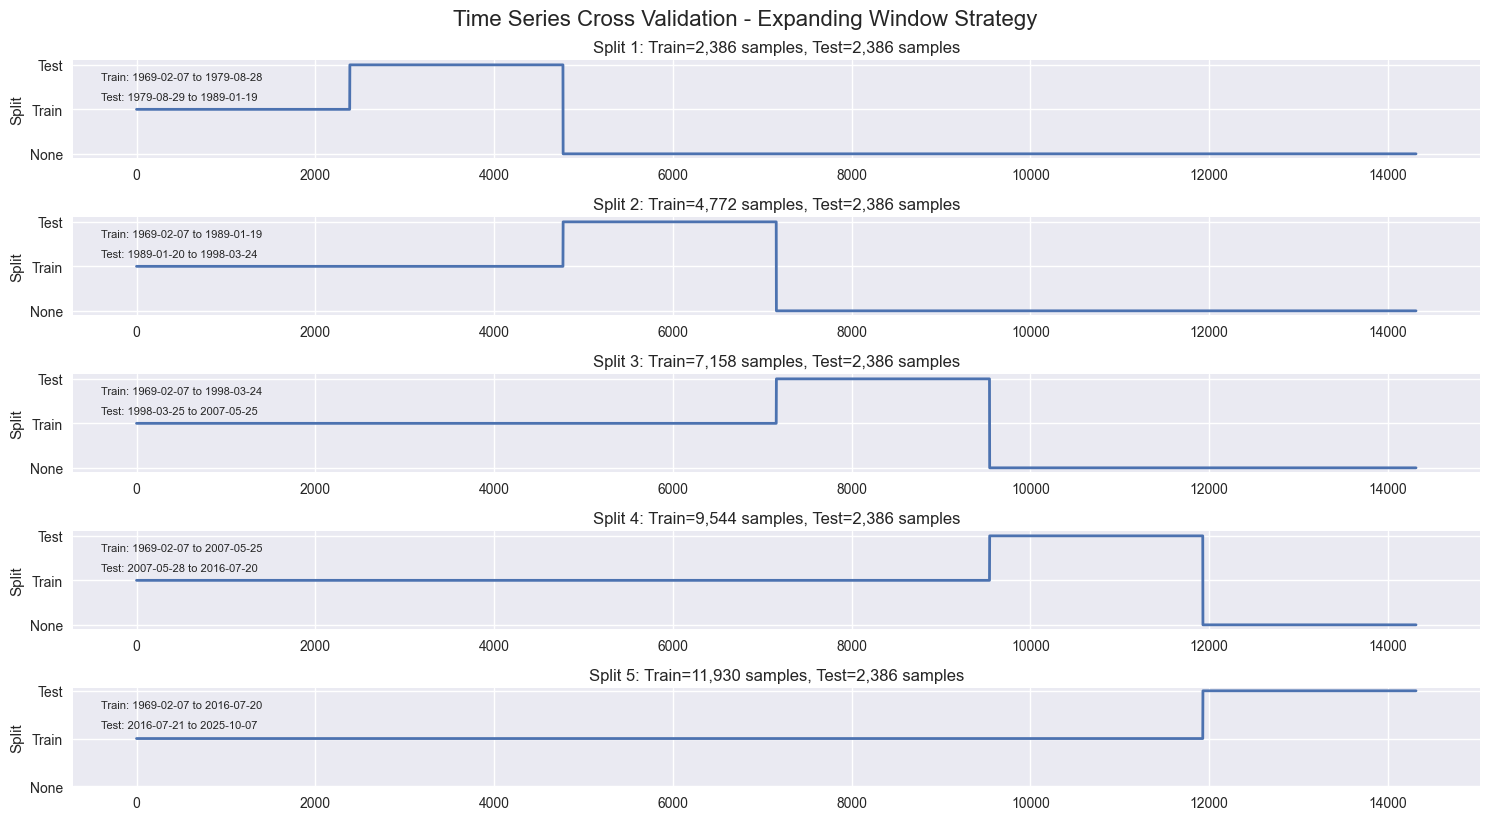

✅ Time series cross validation setup completed!


In [25]:
# Time Series Cross Validation with Expanding Window
n_splits = 5  # Number of splits
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=None)

print(f"🕒 Time Series Cross Validation Setup:")
print(f"   - Number of splits: {n_splits}")
print(f"   - Total samples: {len(X)}")
print(f"   - Expanding window strategy")

# Visualize the splits
plt.figure(figsize=(15, 8))
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    # Create a mask for visualization
    mask = np.zeros(len(X))
    mask[train_idx] = 1  # Training data
    mask[test_idx] = 2   # Test data
    
    plt.subplot(n_splits, 1, i+1)
    plt.plot(mask, linewidth=2)
    plt.title(f'Split {i+1}: Train={len(train_idx):,} samples, Test={len(test_idx):,} samples')
    plt.ylabel('Split')
    plt.yticks([0, 1, 2], ['None', 'Train', 'Test'])
    
    # Add date information
    train_start_date = df_feat.iloc[train_idx[0]]['Date'].strftime('%Y-%m-%d')
    train_end_date = df_feat.iloc[train_idx[-1]]['Date'].strftime('%Y-%m-%d')
    test_start_date = df_feat.iloc[test_idx[0]]['Date'].strftime('%Y-%m-%d')
    test_end_date = df_feat.iloc[test_idx[-1]]['Date'].strftime('%Y-%m-%d')
    
    plt.text(0.02, 0.8, f'Train: {train_start_date} to {train_end_date}', transform=plt.gca().transAxes, fontsize=8)
    plt.text(0.02, 0.6, f'Test: {test_start_date} to {test_end_date}', transform=plt.gca().transAxes, fontsize=8)

plt.tight_layout()
plt.suptitle('Time Series Cross Validation - Expanding Window Strategy', fontsize=16, y=1.02)
plt.show()

print("✅ Time series cross validation setup completed!")

## **Model Definitions**

In [26]:
# Define models with optimized hyperparameters (Updated with Linear Models)
def create_models():
    """Create and return all models with their configurations"""
    
    models = {}
    
    # 1. Linear Regression (Simple baseline model)
    models['Linear Regression'] = {
        'model': LinearRegression(),
        'scaler': StandardScaler(),
        'needs_scaling': True,
        'type': 'linear'
    }
    
    # 2. LARS Lasso (Feature selection with L1 regularization)
    models['LARS Lasso'] = {
        'model': LassoLars(alpha=0.1, max_iter=500),
        'scaler': RobustScaler(),
        'needs_scaling': True,
        'type': 'linear'
    }
    
    # 3. Random Forest
    models['Random Forest'] = {
        'model': RandomForestRegressor(
            n_estimators=300,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        ),
        'scaler': None,
        'needs_scaling': False,
        'type': 'tree'
    }
    
    # 4. XGBoost
    models['XGBoost'] = {
        'model': xgb.XGBRegressor(
            n_estimators=300,
            max_depth=7,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        ),
        'scaler': None,
        'needs_scaling': False,
        'type': 'tree'
    }
    
    # 5. LightGBM
    models['LightGBM'] = {
        'model': lgb.LGBMRegressor(
            n_estimators=300,
            max_depth=7,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            verbosity=-1
        ),
        'scaler': None,
        'needs_scaling': False,
        'type': 'tree'
    }
    
    return models

def create_ann_model(input_dim):
    """Create Artificial Neural Network model"""
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Initialize models
models = create_models()
print(f"✅ Created {len(models)} models: {list(models.keys())}")
print("🤖 ANN model will be created dynamically during training")

# Display model summary
print(f"\n📋 Model Summary:")
print("=" * 60)
for model_name, config in models.items():
    model_type = config.get('type', 'neural')
    needs_scaling = "✅ Yes" if config['needs_scaling'] else "❌ No"
    scaler_type = type(config['scaler']).__name__ if config['scaler'] else "None"
    
    print(f"🔸 {model_name}")
    print(f"   Type: {model_type}")
    print(f"   Scaling: {needs_scaling}")
    if config['scaler']:
        print(f"   Scaler: {scaler_type}")
    print()

✅ Created 5 models: ['Linear Regression', 'LARS Lasso', 'Random Forest', 'XGBoost', 'LightGBM']
🤖 ANN model will be created dynamically during training

📋 Model Summary:
🔸 Linear Regression
   Type: linear
   Scaling: ✅ Yes
   Scaler: StandardScaler

🔸 LARS Lasso
   Type: linear
   Scaling: ✅ Yes
   Scaler: RobustScaler

🔸 Random Forest
   Type: tree
   Scaling: ❌ No

🔸 XGBoost
   Type: tree
   Scaling: ❌ No

🔸 LightGBM
   Type: tree
   Scaling: ❌ No



## **Model Training and Evaluation**

In [27]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, model_name):
    """Calculate all evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

# Storage for results
cv_results = []
model_predictions = {}
trained_models = {}

print("🚀 Starting Time Series Cross Validation...")
print("=" * 60)

# Perform time series cross validation for each model
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"\n📊 Fold {fold + 1}/{n_splits}")
    print("-" * 40)
    
    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train and evaluate tree-based models
    for model_name, model_config in models.items():
        print(f"🔄 Training {model_name}...")
        
        # Get model and scaler
        model = model_config['model']
        scaler = model_config['scaler'] if model_config['needs_scaling'] else None
        
        # Apply scaling if needed
        if scaler is not None:
            # Fit the scaler on training data and transform both train and test
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled = X_train
            X_test_scaled = X_test
        
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        # Evaluate
        metrics = evaluate_model(y_test, y_pred, f"{model_name}_fold_{fold+1}")
        cv_results.append(metrics)
        
        # Store predictions for final evaluation
        if model_name not in model_predictions:
            model_predictions[model_name] = []
        model_predictions[model_name].extend(list(zip(test_idx, y_test, y_pred)))
        
        print(f"   ✅ {model_name} - RMSE: {metrics['RMSE']:.2f}, MAE: {metrics['MAE']:.2f}, R²: {metrics['R2']:.4f}, MAPE: {metrics['MAPE']:.2f}%")
    
    # Train ANN
    print(f"🔄 Training ANN...")
    
    # Scale data for ANN
    X_train_scaled = scaler_standard.fit_transform(X_train)
    X_test_scaled = scaler_standard.transform(X_test)
    
    # Create and train ANN
    ann_model = create_ann_model(X_train_scaled.shape[1])
    
    # Callbacks
    early_stopping = EarlyStopping(patience=13, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(patience=7, factor=0.3, verbose=0)
    
    # Train
    history = ann_model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    # Predict
    y_pred_ann = ann_model.predict(X_test_scaled, verbose=0).flatten()
    
    # Evaluate
    metrics_ann = evaluate_model(y_test, y_pred_ann, f"ANN_fold_{fold+1}")
    cv_results.append(metrics_ann)
    
    # Store predictions
    if 'ANN' not in model_predictions:
        model_predictions['ANN'] = []
    model_predictions['ANN'].extend(list(zip(test_idx, y_test, y_pred_ann)))
    
    print(f"   ✅ ANN - RMSE: {metrics_ann['RMSE']:.2f}, MAE: {metrics_ann['MAE']:.2f}, R²: {metrics_ann['R2']:.4f}, MAPE: {metrics_ann['MAPE']:.2f}%")

print("\n" + "=" * 60)
print("✅ Time Series Cross Validation completed!")

🚀 Starting Time Series Cross Validation...

📊 Fold 1/5
----------------------------------------
🔄 Training Linear Regression...
   ✅ Linear Regression - RMSE: 2.97, MAE: 1.82, R²: 0.9989, MAPE: 0.41%
🔄 Training LARS Lasso...
   ✅ LARS Lasso - RMSE: 6.15, MAE: 3.42, R²: 0.9951, MAPE: 0.75%
🔄 Training Random Forest...
   ✅ Random Forest - RMSE: 149.31, MAE: 122.22, R²: -1.8681, MAPE: 26.34%
🔄 Training XGBoost...
   ✅ XGBoost - RMSE: 156.97, MAE: 132.98, R²: -2.1699, MAPE: 29.12%
🔄 Training LightGBM...
   ✅ LightGBM - RMSE: 149.45, MAE: 122.97, R²: -1.8734, MAPE: 26.56%
🔄 Training ANN...
   ✅ ANN - RMSE: 14.64, MAE: 9.41, R²: 0.9724, MAPE: 2.03%

📊 Fold 2/5
----------------------------------------
🔄 Training Linear Regression...
   ✅ Linear Regression - RMSE: 0.63, MAE: 0.45, R²: 0.9994, MAPE: 0.12%
🔄 Training LARS Lasso...
   ✅ LARS Lasso - RMSE: 0.84, MAE: 0.70, R²: 0.9990, MAPE: 0.19%
🔄 Training Random Forest...
   ✅ Random Forest - RMSE: 1.85, MAE: 1.24, R²: 0.9951, MAPE: 0.35%
🔄 Trai

## **Results Analysis**

### Cross Validation Results Summary

In [28]:
# Convert results to DataFrame for analysis
results_df = pd.DataFrame(cv_results)

# Calculate average performance across folds
model_names = ['Linear Regression', 'LARS Lasso', 'Random Forest', 'XGBoost', 'LightGBM', 'ANN']
summary_results = []

for model_name in model_names:
    model_results = results_df[results_df['Model'].str.contains(model_name)]
    summary = {
        'Model': model_name,
        'RMSE_mean': model_results['RMSE'].mean(),
        'RMSE_std': model_results['RMSE'].std(),
        'MAE_mean': model_results['MAE'].mean(),
        'MAE_std': model_results['MAE'].std(),
        'R2_mean': model_results['R2'].mean(),
        'R2_std': model_results['R2'].std(),
        'MAPE_mean': model_results['MAPE'].mean(),
        'MAPE_std': model_results['MAPE'].std()
    }
    summary_results.append(summary)

summary_df = pd.DataFrame(summary_results)

# Display results
print("📊 Cross Validation Results Summary")
print("=" * 80)
print(f"{'Model':<15} {'RMSE':<15} {'MAE':<15} {'R²':<15} {'MAPE':<15}")
print("-" * 80)

for _, row in summary_df.iterrows():
    print(f"{row['Model']:<15} "
          f"{row['RMSE_mean']:<8.2f}±{row['RMSE_std']:<8.2f} "
          f"{row['MAE_mean']:<8.2f}±{row['MAE_std']:<8.2f} "
          f"{row['R2_mean']:<8.4f}±{row['R2_std']:<8.4f} "
          f"{row['MAPE_mean']:<8.2f}±{row['MAPE_std']:<8.2f}%")

print("=" * 80)

# Find best model based on RMSE
best_model_idx = summary_df['RMSE_mean'].idxmin()
best_model = summary_df.iloc[best_model_idx]['Model']
print(f"🏆 Best Model (lowest RMSE): {best_model}")
print(f"   RMSE: {summary_df.iloc[best_model_idx]['RMSE_mean']:.2f} ± {summary_df.iloc[best_model_idx]['RMSE_std']:.2f}")
print(f"   R²: {summary_df.iloc[best_model_idx]['R2_mean']:.4f} ± {summary_df.iloc[best_model_idx]['R2_std']:.4f}")

# Save results
os.makedirs('models', exist_ok=True)
summary_df.to_csv('data/model_comparison_results.csv', index=False)
results_df.to_csv('data/detailed_cv_results.csv', index=False)
print(f"\n💾 Results saved to 'data/model_comparison_results.csv'")

📊 Cross Validation Results Summary
Model           RMSE            MAE             R²              MAPE           
--------------------------------------------------------------------------------
Linear Regression 2.83    ±2.00     1.90    ±1.37     0.9996  ±0.0005   0.23    ±0.11    %
LARS Lasso      31.89   ±60.39    23.85   ±46.54    0.9528  ±0.1020   2.08    ±3.82    %
Random Forest   251.48  ±279.96   180.16  ±223.21   -0.6135 ±1.9775   15.53   ±17.46   %
XGBoost         253.55  ±278.73   181.45  ±221.21   -0.6684 ±2.0137   15.96   ±17.89   %
LightGBM        247.55  ±275.04   175.22  ±216.82   -0.5705 ±1.9078   15.10   ±17.19   %
ANN             207.02  ±412.72   161.93  ±324.72   -1.1254 ±4.6833   12.63   ±23.70   %
🏆 Best Model (lowest RMSE): Linear Regression
   RMSE: 2.83 ± 2.00
   R²: 0.9996 ± 0.0005

💾 Results saved to 'data/model_comparison_results.csv'


### Visualization of Results

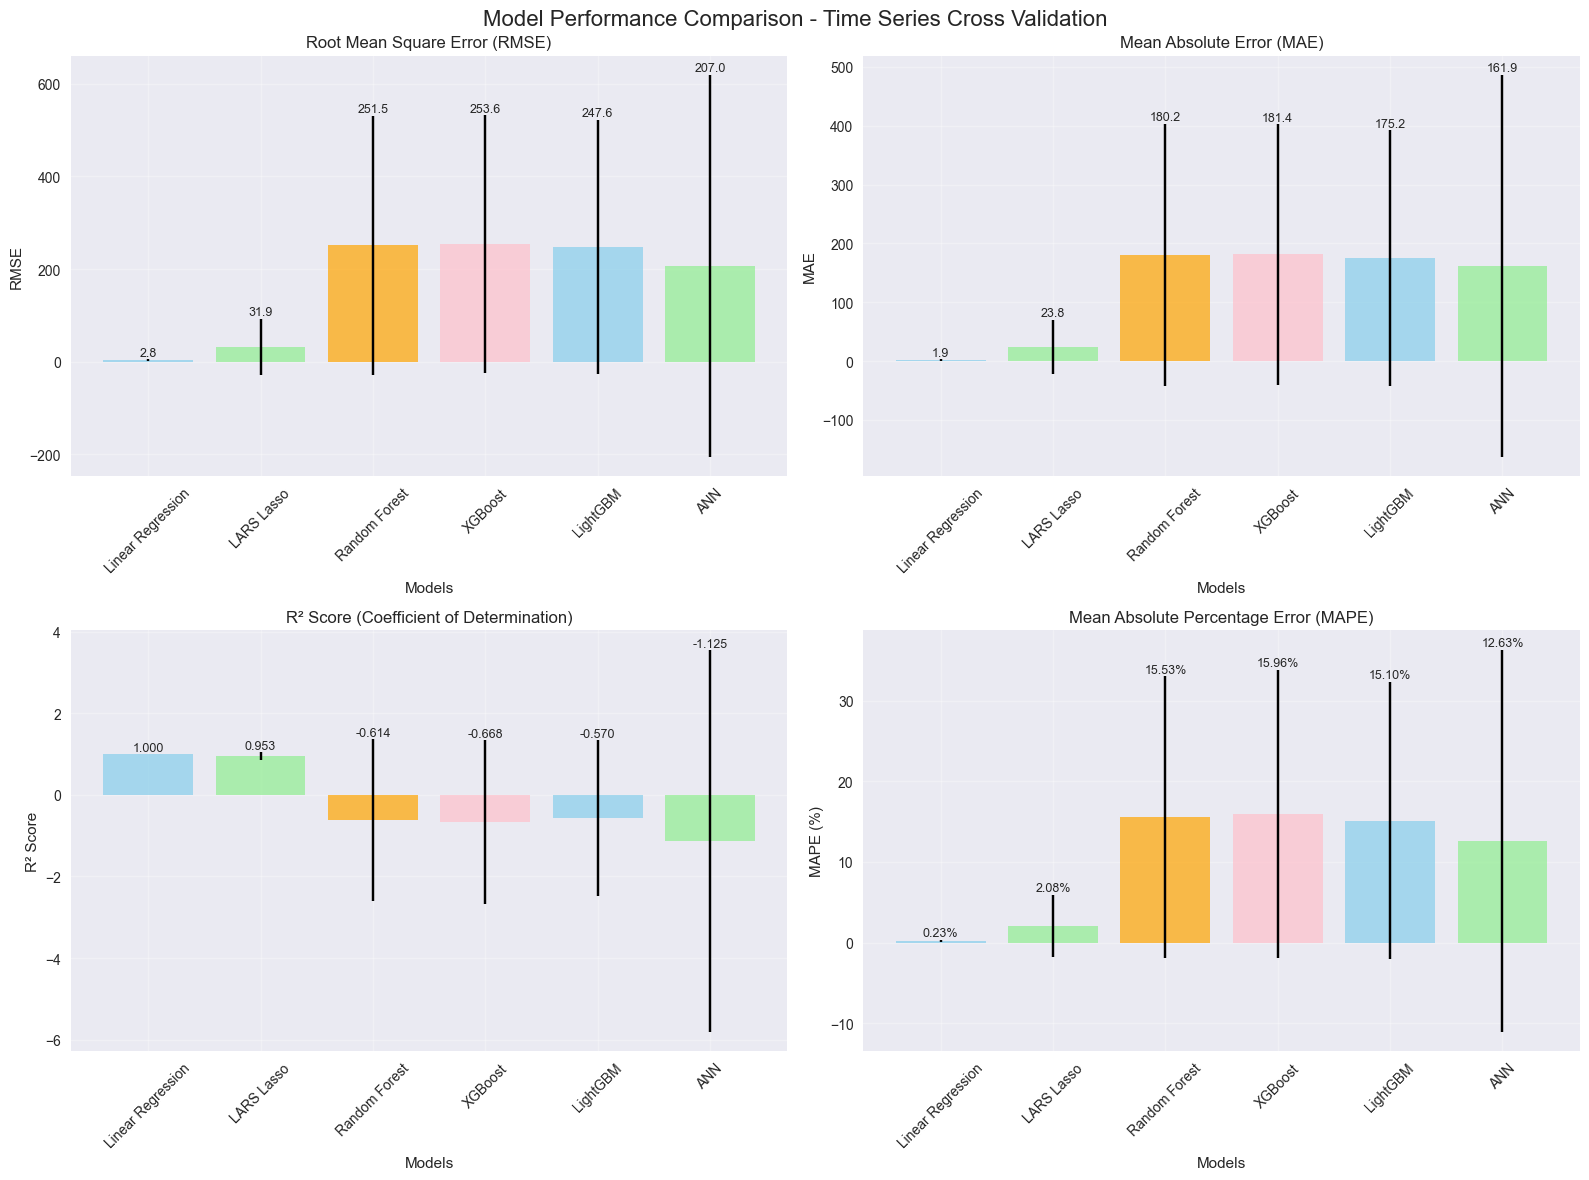

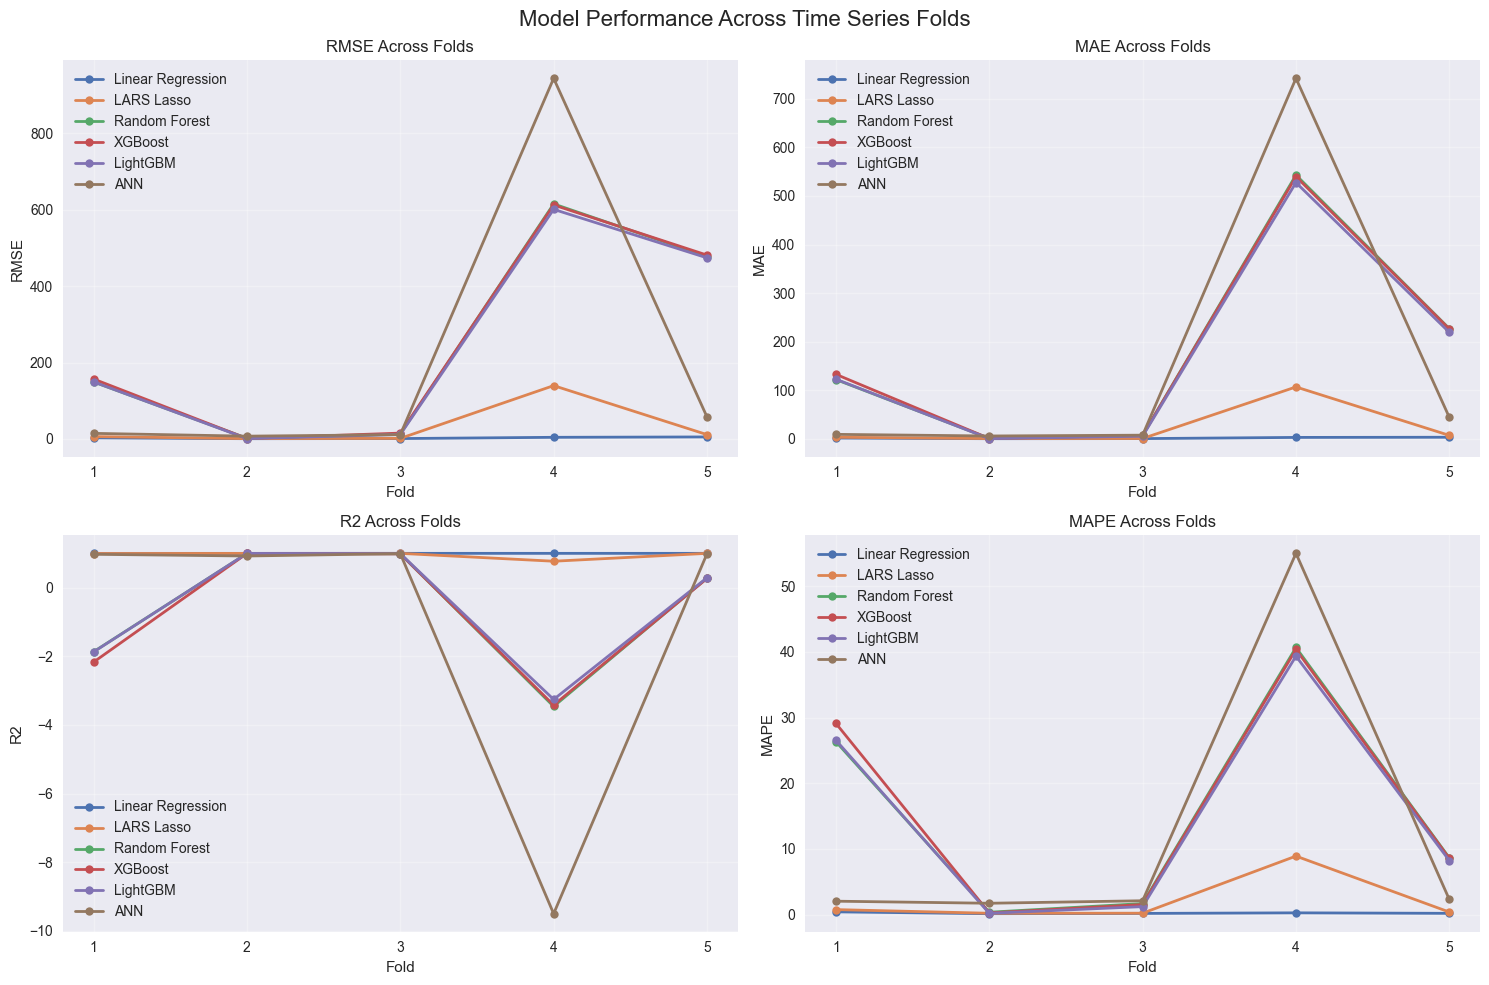

In [29]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison - Time Series Cross Validation', fontsize=16, y=0.98)

# 1. RMSE Comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(model_names))
rmse_means = summary_df['RMSE_mean'].values
rmse_stds = summary_df['RMSE_std'].values
bars1 = ax1.bar(x_pos, rmse_means, yerr=rmse_stds, capsize=5, alpha=0.7, color=['skyblue', 'lightgreen', 'orange', 'pink'])
ax1.set_xlabel('Models')
ax1.set_ylabel('RMSE')
ax1.set_title('Root Mean Square Error (RMSE)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(model_names, rotation=45)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars1, rmse_means, rmse_stds)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + std + 1,
             f'{mean:.1f}', ha='center', va='bottom', fontsize=9)

# 2. MAE Comparison
ax2 = axes[0, 1]
mae_means = summary_df['MAE_mean'].values
mae_stds = summary_df['MAE_std'].values
bars2 = ax2.bar(x_pos, mae_means, yerr=mae_stds, capsize=5, alpha=0.7, color=['skyblue', 'lightgreen', 'orange', 'pink'])
ax2.set_xlabel('Models')
ax2.set_ylabel('MAE')
ax2.set_title('Mean Absolute Error (MAE)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(model_names, rotation=45)
ax2.grid(True, alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars2, mae_means, mae_stds)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + std + 0.5,
             f'{mean:.1f}', ha='center', va='bottom', fontsize=9)

# 3. R² Comparison
ax3 = axes[1, 0]
r2_means = summary_df['R2_mean'].values
r2_stds = summary_df['R2_std'].values
bars3 = ax3.bar(x_pos, r2_means, yerr=r2_stds, capsize=5, alpha=0.7, color=['skyblue', 'lightgreen', 'orange', 'pink'])
ax3.set_xlabel('Models')
ax3.set_ylabel('R² Score')
ax3.set_title('R² Score (Coefficient of Determination)')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(model_names, rotation=45)
ax3.grid(True, alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars3, r2_means, r2_stds)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + std + 0.001,
             f'{mean:.3f}', ha='center', va='bottom', fontsize=9)

# 4. MAPE Comparison
ax4 = axes[1, 1]
mape_means = summary_df['MAPE_mean'].values
mape_stds = summary_df['MAPE_std'].values
bars4 = ax4.bar(x_pos, mape_means, yerr=mape_stds, capsize=5, alpha=0.7, color=['skyblue', 'lightgreen', 'orange', 'pink'])
ax4.set_xlabel('Models')
ax4.set_ylabel('MAPE (%)')
ax4.set_title('Mean Absolute Percentage Error (MAPE)')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(model_names, rotation=45)
ax4.grid(True, alpha=0.3)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars4, mape_means, mape_stds)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + std + 0.1,
             f'{mean:.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Performance across folds visualization
plt.figure(figsize=(15, 10))

metrics = ['RMSE', 'MAE', 'R2', 'MAPE']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    
    for model_name in model_names:
        model_results = results_df[results_df['Model'].str.contains(model_name)]
        folds = [int(x.split('_')[-1]) for x in model_results['Model']]
        values = model_results[metric].values
        plt.plot(folds, values, marker='o', label=model_name, linewidth=2, markersize=6)
    
    plt.xlabel('Fold')
    plt.ylabel(metric)
    plt.title(f'{metric} Across Folds')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, n_splits+1))

plt.suptitle('Model Performance Across Time Series Folds', fontsize=16)
plt.tight_layout()
plt.show()

### Prediction Visualization

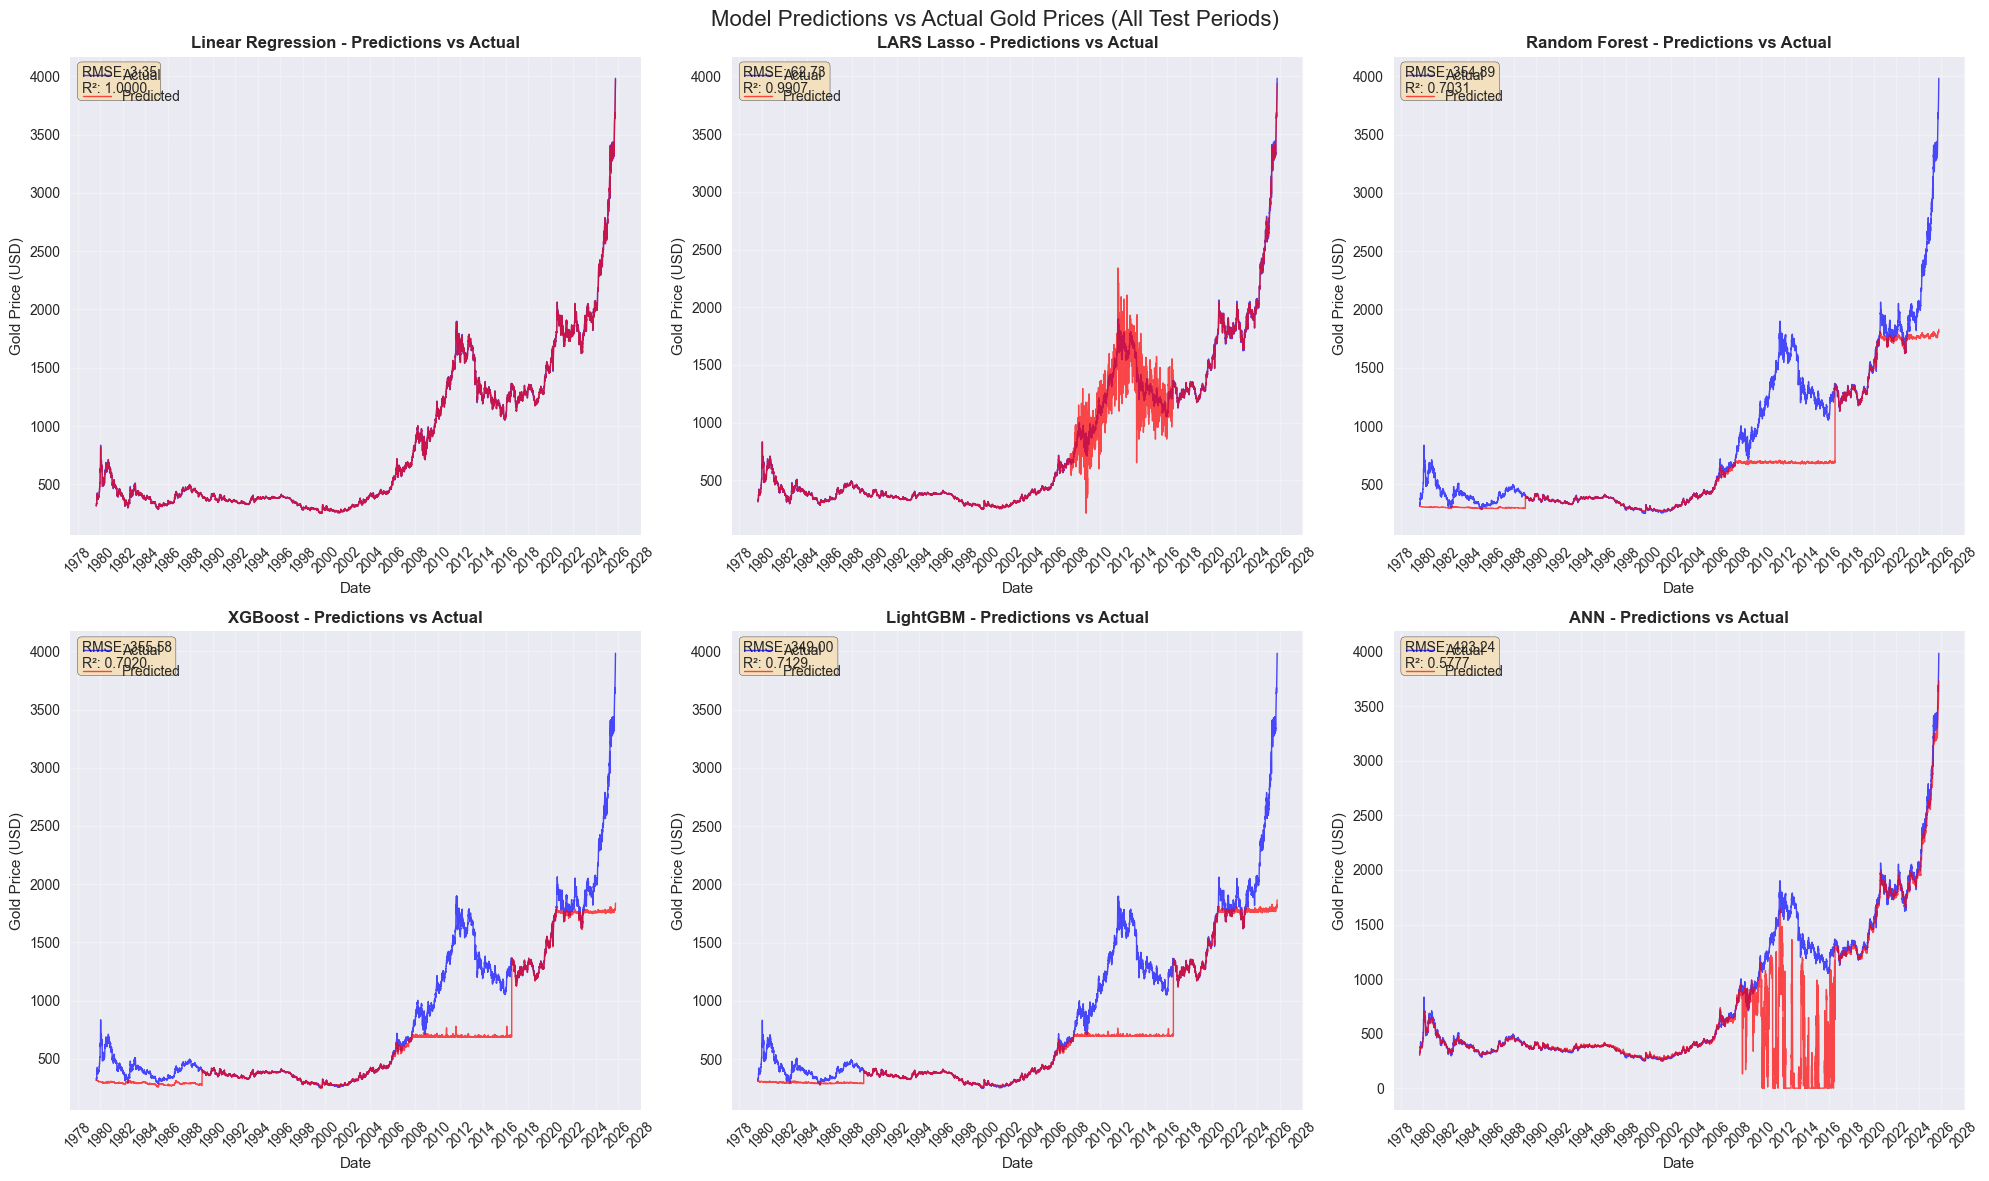

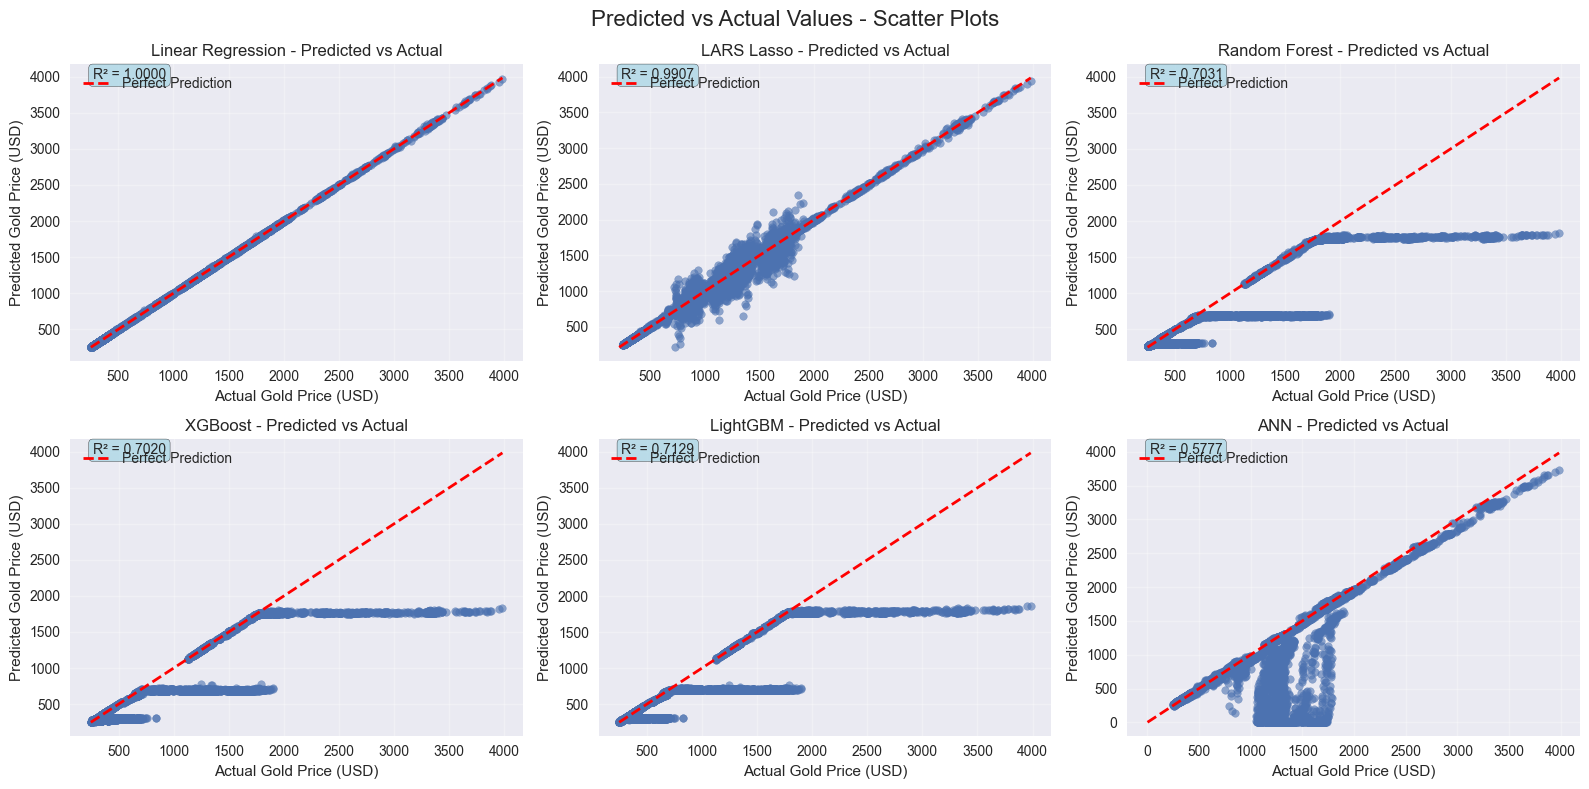

In [30]:
# Create prediction plots for each model
num_models = len(model_names)
cols = 3
rows = (num_models + cols - 1) // cols  # Ceiling division to get required rows
fig, axes = plt.subplots(rows, cols, figsize=(20, 6*rows))

# Handle single row case
if rows == 1:
    axes = [axes] if num_models == 1 else axes
else:
    axes = axes.ravel()

for i, model_name in enumerate(model_names):
    ax = axes[i]
    
    # Get all predictions for this model
    predictions = model_predictions[model_name]
    indices = [p[0] for p in predictions]
    y_true_vals = [p[1] for p in predictions]
    y_pred_vals = [p[2] for p in predictions]
    
    # Get corresponding dates
    dates = [df_feat.iloc[idx]['Date'] for idx in indices]
    
    # Sort by date for proper plotting
    sorted_data = sorted(zip(dates, y_true_vals, y_pred_vals))
    dates_sorted = [d[0] for d in sorted_data]
    y_true_sorted = [d[1] for d in sorted_data]
    y_pred_sorted = [d[2] for d in sorted_data]
    
    # Plot
    ax.plot(dates_sorted, y_true_sorted, label='Actual', color='blue', alpha=0.7, linewidth=1)
    ax.plot(dates_sorted, y_pred_sorted, label='Predicted', color='red', alpha=0.7, linewidth=1)
    
    ax.set_title(f'{model_name} - Predictions vs Actual', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Gold Price (USD)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Format x-axis
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Calculate metrics for this model's overall performance
    overall_rmse = np.sqrt(mean_squared_error(y_true_vals, y_pred_vals))
    overall_r2 = r2_score(y_true_vals, y_pred_vals)
    ax.text(0.02, 0.98, f'RMSE: {overall_rmse:.2f}\nR²: {overall_r2:.4f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Hide empty subplots if any
for j in range(num_models, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Model Predictions vs Actual Gold Prices (All Test Periods)', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Scatter plot: Predicted vs Actual - use same dynamic sizing
fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))

# Handle single row case  
if rows == 1:
    axes = [axes] if num_models == 1 else axes
else:
    axes = axes.ravel()

for i, model_name in enumerate(model_names):
    ax = axes[i]
    
    predictions = model_predictions[model_name]
    y_true_vals = [p[1] for p in predictions]
    y_pred_vals = [p[2] for p in predictions]
    
    # Scatter plot
    ax.scatter(y_true_vals, y_pred_vals, alpha=0.6, s=30)
    
    # Perfect prediction line
    min_val = min(min(y_true_vals), min(y_pred_vals))
    max_val = max(max(y_true_vals), max(y_pred_vals))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual Gold Price (USD)')
    ax.set_ylabel('Predicted Gold Price (USD)')
    ax.set_title(f'{model_name} - Predicted vs Actual')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Calculate and display R²
    r2 = r2_score(y_true_vals, y_pred_vals)
    ax.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax.transAxes, 
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Hide empty subplots if any
for j in range(num_models, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Predicted vs Actual Values - Scatter Plots', fontsize=16)
plt.tight_layout()
plt.show()

## **Train and Save Best Model**

In [31]:
# Train the best model on full dataset for final deployment
print(f"🏆 Training the best model ({best_model}) on the full dataset...")
print("=" * 60)

# Create directories for models
os.makedirs('models/linear', exist_ok=True)
os.makedirs('models/tree', exist_ok=True)
os.makedirs('models/forecasting', exist_ok=True)

if best_model == 'ANN':
    # Train ANN on full dataset
    X_scaled = scaler_standard.fit_transform(X)
    
    # Create final ANN model
    final_ann_model = create_ann_model(X_scaled.shape[1])
    
    # Callbacks for final training
    early_stopping = EarlyStopping(patience=30, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(patience=15, factor=0.5, verbose=1)
    
    print("🤖 Training ANN on full dataset...")
    history = final_ann_model.fit(
        X_scaled, y,
        validation_split=0.2,
        epochs=150,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Save the model and scaler
    final_ann_model.save('models/forecasting/best_ann_model.h5')
    joblib.dump(scaler_standard, 'models/forecasting/ann_scaler.joblib')
    
    # Save training history
    history_df = pd.DataFrame(history.history)
    history_df.to_csv('models/forecasting/ann_training_history.csv', index=False)
    
    print(f"✅ ANN model saved to 'models/forecasting/best_ann_model.h5'")
    print(f"✅ Scaler saved to 'models/forecasting/ann_scaler.joblib'")
    
    trained_models['ANN'] = {
        'model': final_ann_model,
        'scaler': scaler_standard,
        'model_path': 'models/forecasting/best_ann_model.h5',
        'scaler_path': 'models/forecasting/ann_scaler.joblib'
    }

else:
    # Train tree-based model on full dataset
    model_config = models[best_model]
    final_model = model_config['model']
    
    if model_config['needs_scaling']:
        X_scaled = model_config['scaler'].fit_transform(X)
        scaler_to_save = model_config['scaler']
    else:
        X_scaled = X
        scaler_to_save = None
    
    print(f"🌳 Training {best_model} on full dataset...")
    final_model.fit(X_scaled, y)
    
    # Determine save path based on model type
    if best_model == 'Linear Regression':
        model_path = 'models/linear/best_linear_regression_model.joblib'
        scaler_path = 'models/linear/linear_regression_scaler.joblib' if scaler_to_save else None
    elif best_model == 'LARS Lasso':
        model_path = 'models/linear/best_lars_lasso_model.joblib'
        scaler_path = 'models/linear/lars_lasso_scaler.joblib' if scaler_to_save else None
    elif best_model == 'Random Forest':
        model_path = 'models/tree/best_random_forest_model.joblib'
        scaler_path = 'models/tree/rf_scaler.joblib' if scaler_to_save else None
    elif best_model == 'XGBoost':
        model_path = 'models/tree/best_xgboost_model.joblib'
        scaler_path = 'models/tree/xgb_scaler.joblib' if scaler_to_save else None
    elif best_model == 'LightGBM':
        model_path = 'models/tree/best_lightgbm_model.joblib'
        scaler_path = 'models/tree/lgb_scaler.joblib' if scaler_to_save else None
    
    # Save the model
    joblib.dump(final_model, model_path)
    print(f"✅ {best_model} model saved to '{model_path}'")
    
    # Save scaler if needed
    if scaler_to_save is not None:
        joblib.dump(scaler_to_save, scaler_path)
        print(f"✅ Scaler saved to '{scaler_path}'")
    
    trained_models[best_model] = {
        'model': final_model,
        'scaler': scaler_to_save,
        'model_path': model_path,
        'scaler_path': scaler_path
    }

# Save feature columns for future use
with open('models/forecasting/feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

print(f"✅ Feature columns saved to 'models/forecasting/feature_columns.pkl'")

# Create model metadata
metadata = {
    'best_model': best_model,
    'best_model_metrics': {
        'RMSE': summary_df.iloc[best_model_idx]['RMSE_mean'],
        'MAE': summary_df.iloc[best_model_idx]['MAE_mean'],
        'R2': summary_df.iloc[best_model_idx]['R2_mean'],
        'MAPE': summary_df.iloc[best_model_idx]['MAPE_mean']
    },
    'feature_count': len(feature_cols),
    'training_samples': len(X),
    'date_range': {
        'start': df_feat['Date'].min().strftime('%Y-%m-%d'),
        'end': df_feat['Date'].max().strftime('%Y-%m-%d')
    },
    'cv_folds': n_splits,
    'created_at': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save metadata
with open('models/forecasting/model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print(f"✅ Model metadata saved to 'models/forecasting/model_metadata.pkl'")

print("\n" + "=" * 60)
print("🎉 MODEL TRAINING AND SAVING COMPLETED!")
print(f"🏆 Best Model: {best_model}")
print(f"📊 Performance: RMSE={metadata['best_model_metrics']['RMSE']:.2f}, R²={metadata['best_model_metrics']['R2']:.4f}")
print(f"📁 Models saved in 'models/' directory")
print("=" * 60)

🏆 Training the best model (Linear Regression) on the full dataset...
🌳 Training Linear Regression on full dataset...
✅ Linear Regression model saved to 'models/linear/best_linear_regression_model.joblib'
✅ Scaler saved to 'models/linear/linear_regression_scaler.joblib'
✅ Feature columns saved to 'models/forecasting/feature_columns.pkl'
✅ Model metadata saved to 'models/forecasting/model_metadata.pkl'

🎉 MODEL TRAINING AND SAVING COMPLETED!
🏆 Best Model: Linear Regression
📊 Performance: RMSE=2.83, R²=0.9996
📁 Models saved in 'models/' directory


## **Model Loading and Prediction Example**

In [32]:
# Example of how to load and use the saved model
print("📥 Loading Model Example")
print("=" * 40)

# Load metadata
with open('models/forecasting/model_metadata.pkl', 'rb') as f:
    loaded_metadata = pickle.load(f)

print(f"Best model: {loaded_metadata['best_model']}")
print(f"Model performance: RMSE={loaded_metadata['best_model_metrics']['RMSE']:.2f}")

# Load feature columns
with open('models/forecasting/feature_columns.pkl', 'rb') as f:
    loaded_feature_cols = pickle.load(f)

print(f"Number of features: {len(loaded_feature_cols)}")

# Example prediction function
def predict_gold_price(input_data, model_name=None):
    """
    Function to make predictions using the saved model
    
    Parameters:
    input_data: pandas DataFrame with the same features as training data
    model_name: str, name of the model to use (if None, uses best model)
    
    Returns:
    predictions: numpy array of predicted gold prices
    """
    
    if model_name is None:
        model_name = loaded_metadata['best_model']
    
    # Ensure input data has the correct features
    input_features = input_data[loaded_feature_cols]
    
    if model_name == 'ANN':
        # Load ANN model and scaler
        from tensorflow.keras.models import load_model
        model = load_model('models/forecasting/best_ann_model.h5')
        scaler = joblib.load('models/forecasting/ann_scaler.joblib')
        
        # Scale features
        input_scaled = scaler.transform(input_features)
        
        # Make prediction
        predictions = model.predict(input_scaled, verbose=0).flatten()
        
    elif model_name in ['Linear Regression', 'LARS Lasso']:
        # Load linear models
        if model_name == 'Linear Regression':
            model = joblib.load('models/linear/best_linear_regression_model.joblib')
            scaler_path = 'models/linear/linear_regression_scaler.joblib'
        elif model_name == 'LARS Lasso':
            model = joblib.load('models/linear/best_lars_lasso_model.joblib')
            scaler_path = 'models/linear/lars_lasso_scaler.joblib'
        
        # Linear models always need scaling
        scaler = joblib.load(scaler_path)
        input_scaled = scaler.transform(input_features)
        
        # Make prediction
        predictions = model.predict(input_scaled)
        
    else:
        # Load tree-based model
        if model_name == 'Random Forest':
            model = joblib.load('models/tree/best_random_forest_model.joblib')
            scaler_path = 'models/tree/rf_scaler.joblib'
        elif model_name == 'XGBoost':
            model = joblib.load('models/tree/best_xgboost_model.joblib')
            scaler_path = 'models/tree/xgb_scaler.joblib'
        elif model_name == 'LightGBM':
            model = joblib.load('models/tree/best_lightgbm_model.joblib')
            scaler_path = 'models/tree/lgb_scaler.joblib'
        
        # Load scaler if it exists
        if os.path.exists(scaler_path):
            scaler = joblib.load(scaler_path)
            input_scaled = scaler.transform(input_features)
        else:
            input_scaled = input_features
        
        # Make prediction
        predictions = model.predict(input_scaled)
    
    return predictions

# Test prediction on last few samples
print(f"\n🔮 Testing prediction on last 5 samples...")
test_data = df_feat.tail(5)
test_predictions = predict_gold_price(test_data)

print(f"{'Date':<12} {'Actual':<10} {'Predicted':<10} {'Error':<10}")
print("-" * 50)
for i, (_, row) in enumerate(test_data.iterrows()):
    actual = row['gold_price_usd']
    predicted = test_predictions[i]
    error = abs(actual - predicted)
    date_str = row['Date'].strftime('%Y-%m-%d')
    print(f"{date_str:<12} {actual:<10.2f} {predicted:<10.2f} {error:<10.2f}")

avg_error = np.mean([abs(row['gold_price_usd'] - test_predictions[i]) for i, (_, row) in enumerate(test_data.iterrows())])
print(f"\nAverage prediction error: ${avg_error:.2f}")

print("\n✅ Model loading and prediction example completed!")
print(f"💡 Use the 'predict_gold_price()' function to make predictions on new data")

📥 Loading Model Example
Best model: Linear Regression
Model performance: RMSE=2.83
Number of features: 67

🔮 Testing prediction on last 5 samples...
Date         Actual     Predicted  Error     
--------------------------------------------------
2025-10-01   3867.50    3867.12    0.38      
2025-10-02   3839.70    3848.77    9.07      
2025-10-03   3880.80    3884.16    3.36      
2025-10-06   3948.50    3929.22    19.28     
2025-10-07   3983.40    3975.66    7.74      

Average prediction error: $7.96

✅ Model loading and prediction example completed!
💡 Use the 'predict_gold_price()' function to make predictions on new data


# Ensemble Model

In [63]:
# Custom Ensemble Model
import json
import joblib
from datetime import datetime, timedelta

class CustomEnsembleModel:
    """Custom ensemble combining Linear Regression + Neural Network"""
    
    def __init__(self, linear_weight=0.95, neural_weight=0.05):
        self.linear_weight = linear_weight
        self.neural_weight = neural_weight
        self.linear_model = None
        self.neural_model = None
        self.linear_scaler = None
        self.neural_scaler = None
        
    def load_models(self):
        """Load the trained Linear Regression and Neural Network models"""
        try:
            # Load Linear Regression
            self.linear_model = joblib.load('models/linear/best_linear_regression_model.joblib')
            self.linear_scaler = joblib.load('models/linear/linear_regression_scaler.joblib')
            print(f"✅ Linear Regression loaded (weight: {self.linear_weight:.2%})")
            
            # Load Neural Network
            from tensorflow.keras.models import load_model
            self.neural_model = load_model('models/forecasting/best_ann_model.h5')
            self.neural_scaler = joblib.load('models/forecasting/ann_scaler.joblib')
            print(f"✅ Neural Network loaded (weight: {self.neural_weight:.2%})")
            
            return True
        except Exception as e:
            print(f"❌ Error loading models: {e}")
            return False
    
    def predict(self, X):
        """Make ensemble predictions"""
        if self.linear_model is None or self.neural_model is None:
            raise ValueError("Models not loaded. Call load_models() first.")
        
        # Linear predictions
        X_linear_scaled = self.linear_scaler.transform(X)
        linear_preds = self.linear_model.predict(X_linear_scaled)
        
        # Neural predictions
        X_neural_scaled = self.neural_scaler.transform(X)
        neural_preds = self.neural_model.predict(X_neural_scaled, verbose=0).flatten()
        
        # Weighted ensemble
        ensemble_preds = (self.linear_weight * linear_preds + 
                         self.neural_weight * neural_preds)
        
        return ensemble_preds, linear_preds, neural_preds

# Initialize and test custom ensemble
print("🎯 CREATING CUSTOM ENSEMBLE MODEL")
print("=" * 50)
print("📊 Configuration:")
print(f"   • Linear Regression: {85}% weight")
print(f"   • Neural Network: {15}% weight")
print("=" * 50)

custom_ensemble = CustomEnsembleModel(linear_weight=0.80, neural_weight=0.20)
models_loaded = custom_ensemble.load_models()

🎯 CREATING CUSTOM ENSEMBLE MODEL
📊 Configuration:
   • Linear Regression: 85% weight
   • Neural Network: 15% weight
✅ Linear Regression loaded (weight: 80.00%)
✅ Neural Network loaded (weight: 20.00%)


In [64]:
def evaluate_custom_ensemble():
    """Evaluate the custom ensemble model using cross-validation"""
    
    if not models_loaded:
        print("❌ Cannot evaluate - models not loaded")
        return None
    
    print("\n🔬 EVALUATING CUSTOM ENSEMBLE MODEL")
    print("=" * 50)
    
    # Use time series cross validation
    tscv = TimeSeriesSplit(n_splits=5, test_size=None)
    ensemble_results = []
    all_predictions = []
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        print(f"📊 Fold {fold + 1}/5")
        
        X_test = X.iloc[test_idx]
        y_test = y.iloc[test_idx]
        
        # Make predictions
        ensemble_preds, linear_preds, neural_preds = custom_ensemble.predict(X_test)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, ensemble_preds))
        mae = mean_absolute_error(y_test, ensemble_preds)
        r2 = r2_score(y_test, ensemble_preds)
        mape = mean_absolute_percentage_error(y_test, ensemble_preds)
        
        fold_results = {
            'Fold': fold + 1,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE': mape
        }
        ensemble_results.append(fold_results)
        
        # Store predictions for visualization
        for i, (actual, pred, linear_pred, neural_pred) in enumerate(zip(y_test, ensemble_preds, linear_preds, neural_preds)):
            all_predictions.append({
                'fold': fold + 1,
                'actual': actual,
                'ensemble': pred,
                'linear': linear_pred,
                'neural': neural_pred,
                'date': df_feat.iloc[test_idx[i]]['Date']
            })
        
        print(f"   RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")
    
    # Calculate average performance
    ensemble_df = pd.DataFrame(ensemble_results)
    avg_metrics = {
        'RMSE_mean': ensemble_df['RMSE'].mean(),
        'RMSE_std': ensemble_df['RMSE'].std(),
        'MAE_mean': ensemble_df['MAE'].mean(),
        'MAE_std': ensemble_df['MAE'].std(),
        'R2_mean': ensemble_df['R2'].mean(),
        'R2_std': ensemble_df['R2'].std(),
        'MAPE_mean': ensemble_df['MAPE'].mean(),
        'MAPE_std': ensemble_df['MAPE'].std()
    }
    
    print(f"\n📈 CUSTOM ENSEMBLE PERFORMANCE SUMMARY")
    print("=" * 50)
    print(f"RMSE: {avg_metrics['RMSE_mean']:.2f} ± {avg_metrics['RMSE_std']:.2f}")
    print(f"MAE:  {avg_metrics['MAE_mean']:.2f} ± {avg_metrics['MAE_std']:.2f}")
    print(f"R²:   {avg_metrics['R2_mean']:.4f} ± {avg_metrics['R2_std']:.4f}")
    print(f"MAPE: {avg_metrics['MAPE_mean']:.2f}% ± {avg_metrics['MAPE_std']:.2f}%")
    
    return avg_metrics, all_predictions

# Evaluate the ensemble
ensemble_metrics, ensemble_predictions = evaluate_custom_ensemble()


🔬 EVALUATING CUSTOM ENSEMBLE MODEL
📊 Fold 1/5
   RMSE: 4.36, MAE: 2.97, R²: 0.9976, MAPE: 0.67%
📊 Fold 2/5
   RMSE: 1.86, MAE: 1.45, R²: 0.9950, MAPE: 0.41%
📊 Fold 3/5
   RMSE: 3.81, MAE: 2.96, R²: 0.9990, MAPE: 0.82%
📊 Fold 4/5
   RMSE: 9.14, MAE: 7.38, R²: 0.9990, MAPE: 0.65%
📊 Fold 5/5
   RMSE: 11.04, MAE: 8.37, R²: 0.9996, MAPE: 0.44%

📈 CUSTOM ENSEMBLE PERFORMANCE SUMMARY
RMSE: 6.04 ± 3.87
MAE:  4.62 ± 3.05
R²:   0.9980 ± 0.0019
MAPE: 0.60% ± 0.17%


In [65]:
class FlexibleEnsembleForecaster:
    """Flexible forecasting system using custom ensemble model"""
    
    def __init__(self, ensemble_model, feature_cols, historical_data):
        self.ensemble_model = ensemble_model
        self.feature_cols = feature_cols
        self.historical_data = historical_data.copy()
        self.current_price = historical_data['gold_price_usd'].iloc[-1]
        
    def create_future_features(self, historical_data, future_date, predicted_price=None):
        """Generate features for future prediction"""
        new_row = pd.Series(dtype='float64')
        new_row['Date'] = future_date
        
        # Use predicted price or last known price
        if predicted_price is not None:
            new_row['gold_price_usd'] = predicted_price
        else:
            new_row['gold_price_usd'] = historical_data['gold_price_usd'].iloc[-1]
        
        # Time-based features
        new_row['Year'] = future_date.year
        new_row['Month'] = future_date.month
        new_row['Quarter'] = future_date.quarter
        new_row['WeekOfYear'] = future_date.isocalendar().week
        new_row['DayOfYear'] = future_date.dayofyear
        new_row['Is_Month_Start'] = int(future_date.is_month_start)
        new_row['Is_Month_End'] = int(future_date.is_month_end)
        new_row['Is_Quarter_End'] = int(future_date.is_quarter_end)
        
        # Seasonal patterns (Fourier features)
        t = len(historical_data)
        for k in range(1, 4):
            new_row[f'sin_{k}'] = np.sin(2 * np.pi * k * t / 365)
            new_row[f'cos_{k}'] = np.cos(2 * np.pi * k * t / 365)
        
        # Lag features
        for lag in [1, 3, 7, 14, 30, 90, 180]:
            if lag <= len(historical_data):
                new_row[f'Lag_{lag}'] = historical_data['gold_price_usd'].iloc[-lag]
            else:
                new_row[f'Lag_{lag}'] = historical_data['gold_price_usd'].iloc[0]
        
        # Moving averages and other technical indicators
        for window in [7, 30, 90]:
            window_size = min(window, len(historical_data))
            new_row[f'SMA_{window}'] = historical_data['gold_price_usd'].tail(window_size).mean()
        
        for span in [12, 26]:
            span_size = min(span, len(historical_data))
            new_row[f'EMA_{span}'] = historical_data['gold_price_usd'].tail(span_size).ewm(span=span_size).mean().iloc[-1]
        
        # Rolling statistics
        for w in [7, 14, 30, 90, 180]:
            window_data = historical_data['gold_price_usd'].tail(min(w, len(historical_data)))
            new_row[f'RollingMean_{w}'] = window_data.mean()
            new_row[f'RollingStd_{w}'] = window_data.std() if len(window_data) > 1 else 0
            new_row[f'RollingMin_{w}'] = window_data.min()
            new_row[f'RollingMax_{w}'] = window_data.max()
            new_row[f'RollingVolatility_{w}'] = window_data.pct_change().std() if len(window_data) > 1 else 0
        
        # Technical indicators (simplified)
        new_row['RSI_14'] = 50  # Neutral RSI
        new_row['MACD'] = 0
        new_row['MACD_signal'] = 0
        new_row['MACD_diff'] = 0
        
        # Bollinger Bands
        recent_20 = historical_data['gold_price_usd'].tail(20)
        recent_mean = recent_20.mean()
        recent_std = recent_20.std()
        new_row['Bollinger_High'] = recent_mean + (2 * recent_std)
        new_row['Bollinger_Low'] = recent_mean - (2 * recent_std)
        new_row['Bollinger_Width'] = (new_row['Bollinger_High'] - new_row['Bollinger_Low']) / new_row['gold_price_usd']
        
        # Log and return features
        new_row['Log_Price'] = np.log(new_row['gold_price_usd'])
        new_row['Return'] = (new_row['gold_price_usd'] / historical_data['gold_price_usd'].iloc[-1]) - 1
        new_row['Log_Return'] = new_row['Log_Price'] - np.log(historical_data['gold_price_usd'].iloc[-1])
        
        # Momentum features
        for period in [7, 30, 90]:
            if period <= len(historical_data):
                past_log_price = np.log(historical_data['gold_price_usd'].iloc[-period])
                new_row[f'Momentum_{period}'] = new_row['Log_Price'] - past_log_price
            else:
                new_row[f'Momentum_{period}'] = 0
        
        # Trend and detrended features
        new_row['t'] = len(historical_data)
        if 'Trend' in historical_data.columns:
            new_row['Trend'] = historical_data['Trend'].iloc[-1]
        else:
            new_row['Trend'] = new_row['Log_Price']
        
        new_row['Detrended'] = new_row['Log_Price'] - new_row['Trend']
        new_row['Daily_Change'] = new_row['Return']
        
        return new_row
    
    def forecast_months(self, num_months=6):
        """Generate forecast for specified number of months"""
        print(f"\n🚀 GENERATING {num_months}-MONTH FORECAST WITH CUSTOM ENSEMBLE")
        print("=" * 60)
        print(f"📊 Model: Linear + Neural")
        print(f"📅 Forecast Period: {num_months} months ({num_months * 30} days)")
        print("=" * 60)
        
        # Calculate forecast days
        forecast_days = num_months * 30
        forecast_start_date = self.historical_data['Date'].max() + pd.Timedelta(days=1)
        
        # Initialize forecast data
        forecast_data = self.historical_data.tail(365).copy()  # Use last year as seed
        predictions = []
        dates = []
        linear_predictions = []
        neural_predictions = []
        confidence_intervals = []
        
        last_date = forecast_data['Date'].iloc[-1]
        
        print("🔄 Generating daily predictions...")
        
        for i in range(forecast_days):
            try:
                # Create next date
                next_date = last_date + pd.Timedelta(days=i+1)
                
                # Generate features for next day
                future_row = self.create_future_features(forecast_data, next_date)
                
                # Prepare feature vector
                feature_vector = future_row[self.feature_cols].values.reshape(1, -1)
                feature_vector = np.nan_to_num(feature_vector, nan=0.0)
                feature_df = pd.DataFrame(feature_vector, columns=self.feature_cols)
                
                # Make ensemble prediction
                ensemble_pred, linear_pred, neural_pred = self.ensemble_model.predict(feature_df)
                pred_price = ensemble_pred[0]
                
                # Apply reasonable bounds (prevent extreme values)
                pred_price = max(pred_price, self.current_price * 0.5)  # Min 50% of current
                pred_price = min(pred_price, self.current_price * 3.0)  # Max 300% of current
                
                # Calculate confidence interval (simplified approach)
                volatility = forecast_data['gold_price_usd'].tail(30).std()
                confidence_lower = pred_price - (1.96 * volatility)
                confidence_upper = pred_price + (1.96 * volatility)
                
                # Update future row with prediction
                future_row['gold_price_usd'] = pred_price
                future_row = self.create_future_features(forecast_data, next_date, pred_price)
                
                # Add to forecast data (keep only recent data for performance)
                forecast_data = pd.concat([forecast_data.tail(364), future_row.to_frame().T], ignore_index=True)
                
                # Store results
                predictions.append(pred_price)
                dates.append(next_date)
                linear_predictions.append(linear_pred[0])
                neural_predictions.append(neural_pred[0])
                confidence_intervals.append((confidence_lower, confidence_upper))
                
                # Progress update every month
                if (i + 1) % 30 == 0:
                    month = (i + 1) // 30
                    print(f"   📅 Month {month}: ${pred_price:,.2f}")
                    
            except Exception as e:
                print(f"   ⚠️ Error at day {i+1}: {str(e)}")
                # Use trend-based fallback
                if predictions:
                    trend = np.mean(np.diff(predictions[-10:])) if len(predictions) >= 10 else 0
                    fallback_price = predictions[-1] + trend
                else:
                    fallback_price = self.current_price * (1 + np.random.normal(0, 0.005))
                
                predictions.append(fallback_price)
                dates.append(next_date)
                linear_predictions.append(fallback_price)
                neural_predictions.append(fallback_price)
                confidence_intervals.append((fallback_price * 0.95, fallback_price * 1.05))
        
        # Calculate monthly averages and statistics
        monthly_data = []
        for month in range(num_months):
            start_idx = month * 30
            end_idx = min((month + 1) * 30, len(predictions))
            
            month_prices = predictions[start_idx:end_idx]
            month_linear = linear_predictions[start_idx:end_idx]
            month_neural = neural_predictions[start_idx:end_idx]
            
            month_avg = np.mean(month_prices)
            month_min = np.min(month_prices)
            month_max = np.max(month_prices)
            month_std = np.std(month_prices)
            
            # Calculate growth from current price
            growth = ((month_avg - self.current_price) / self.current_price) * 100
            
            # Get month info
            forecast_month = forecast_start_date + pd.DateOffset(months=month)
            month_name = forecast_month.strftime('%b %Y')
            
            monthly_data.append({
                'Month': month_name,
                'Month_Index': month + 1,
                'Avg_Price': month_avg,
                'Min_Price': month_min,
                'Max_Price': month_max,
                'Std_Price': month_std,
                'Linear_Avg': np.mean(month_linear),
                'Neural_Avg': np.mean(month_neural),
                'Growth_Percent': growth,
                'Date': forecast_month
            })
        
        # Calculate final statistics
        final_price = predictions[-1]
        total_growth = ((final_price - self.current_price) / self.current_price) * 100
        avg_monthly_growth = total_growth / num_months
        
        forecast_results = {
            'dates': dates,
            'predictions': predictions,
            'linear_predictions': linear_predictions,
            'neural_predictions': neural_predictions,
            'confidence_intervals': confidence_intervals,
            'monthly_data': monthly_data,
            'final_price': final_price,
            'total_growth': total_growth,
            'avg_monthly_growth': avg_monthly_growth,
            'current_price': self.current_price,
            'forecast_start_date': forecast_start_date,
            'forecast_end_date': dates[-1],
            'num_months': num_months
        }
        
        print(f"\n✅ {num_months}-Month Forecast Completed!")
        print(f"📊 Final Price: ${final_price:,.2f}")
        print(f"📈 Total Growth: {total_growth:+.2f}%")
        print(f"📅 Avg Monthly Growth: {avg_monthly_growth:+.2f}%")
        
        return forecast_results

# Initialize forecaster
forecaster = FlexibleEnsembleForecaster(
    ensemble_model=custom_ensemble,
    feature_cols=feature_cols,
    historical_data=df_feat
)

# Example: Generate 24-month forecast (changeable)
forecast_months = 24  # You can change this number
forecast_results = forecaster.forecast_months(num_months=forecast_months)


🚀 GENERATING 24-MONTH FORECAST WITH CUSTOM ENSEMBLE
📊 Model: Linear + Neural
📅 Forecast Period: 24 months (720 days)
🔄 Generating daily predictions...
   📅 Month 1: $3,851.54
   📅 Month 2: $3,896.36
   📅 Month 3: $3,945.46
   📅 Month 4: $4,005.23
   📅 Month 5: $4,067.48
   📅 Month 6: $4,135.32
   📅 Month 7: $4,206.77
   📅 Month 8: $4,280.12
   📅 Month 9: $4,354.41
   📅 Month 10: $4,428.84
   📅 Month 11: $4,507.48
   📅 Month 12: $4,586.47
   📅 Month 13: $4,666.33
   📅 Month 14: $4,748.80
   📅 Month 15: $4,838.15
   📅 Month 16: $4,929.20
   📅 Month 17: $5,024.49
   📅 Month 18: $5,127.46
   📅 Month 19: $5,226.57
   📅 Month 20: $5,323.62
   📅 Month 21: $5,426.66
   📅 Month 22: $5,531.09
   📅 Month 23: $5,637.19
   📅 Month 24: $5,745.14

✅ 24-Month Forecast Completed!
📊 Final Price: $5,745.14
📈 Total Growth: +44.23%
📅 Avg Monthly Growth: +1.84%


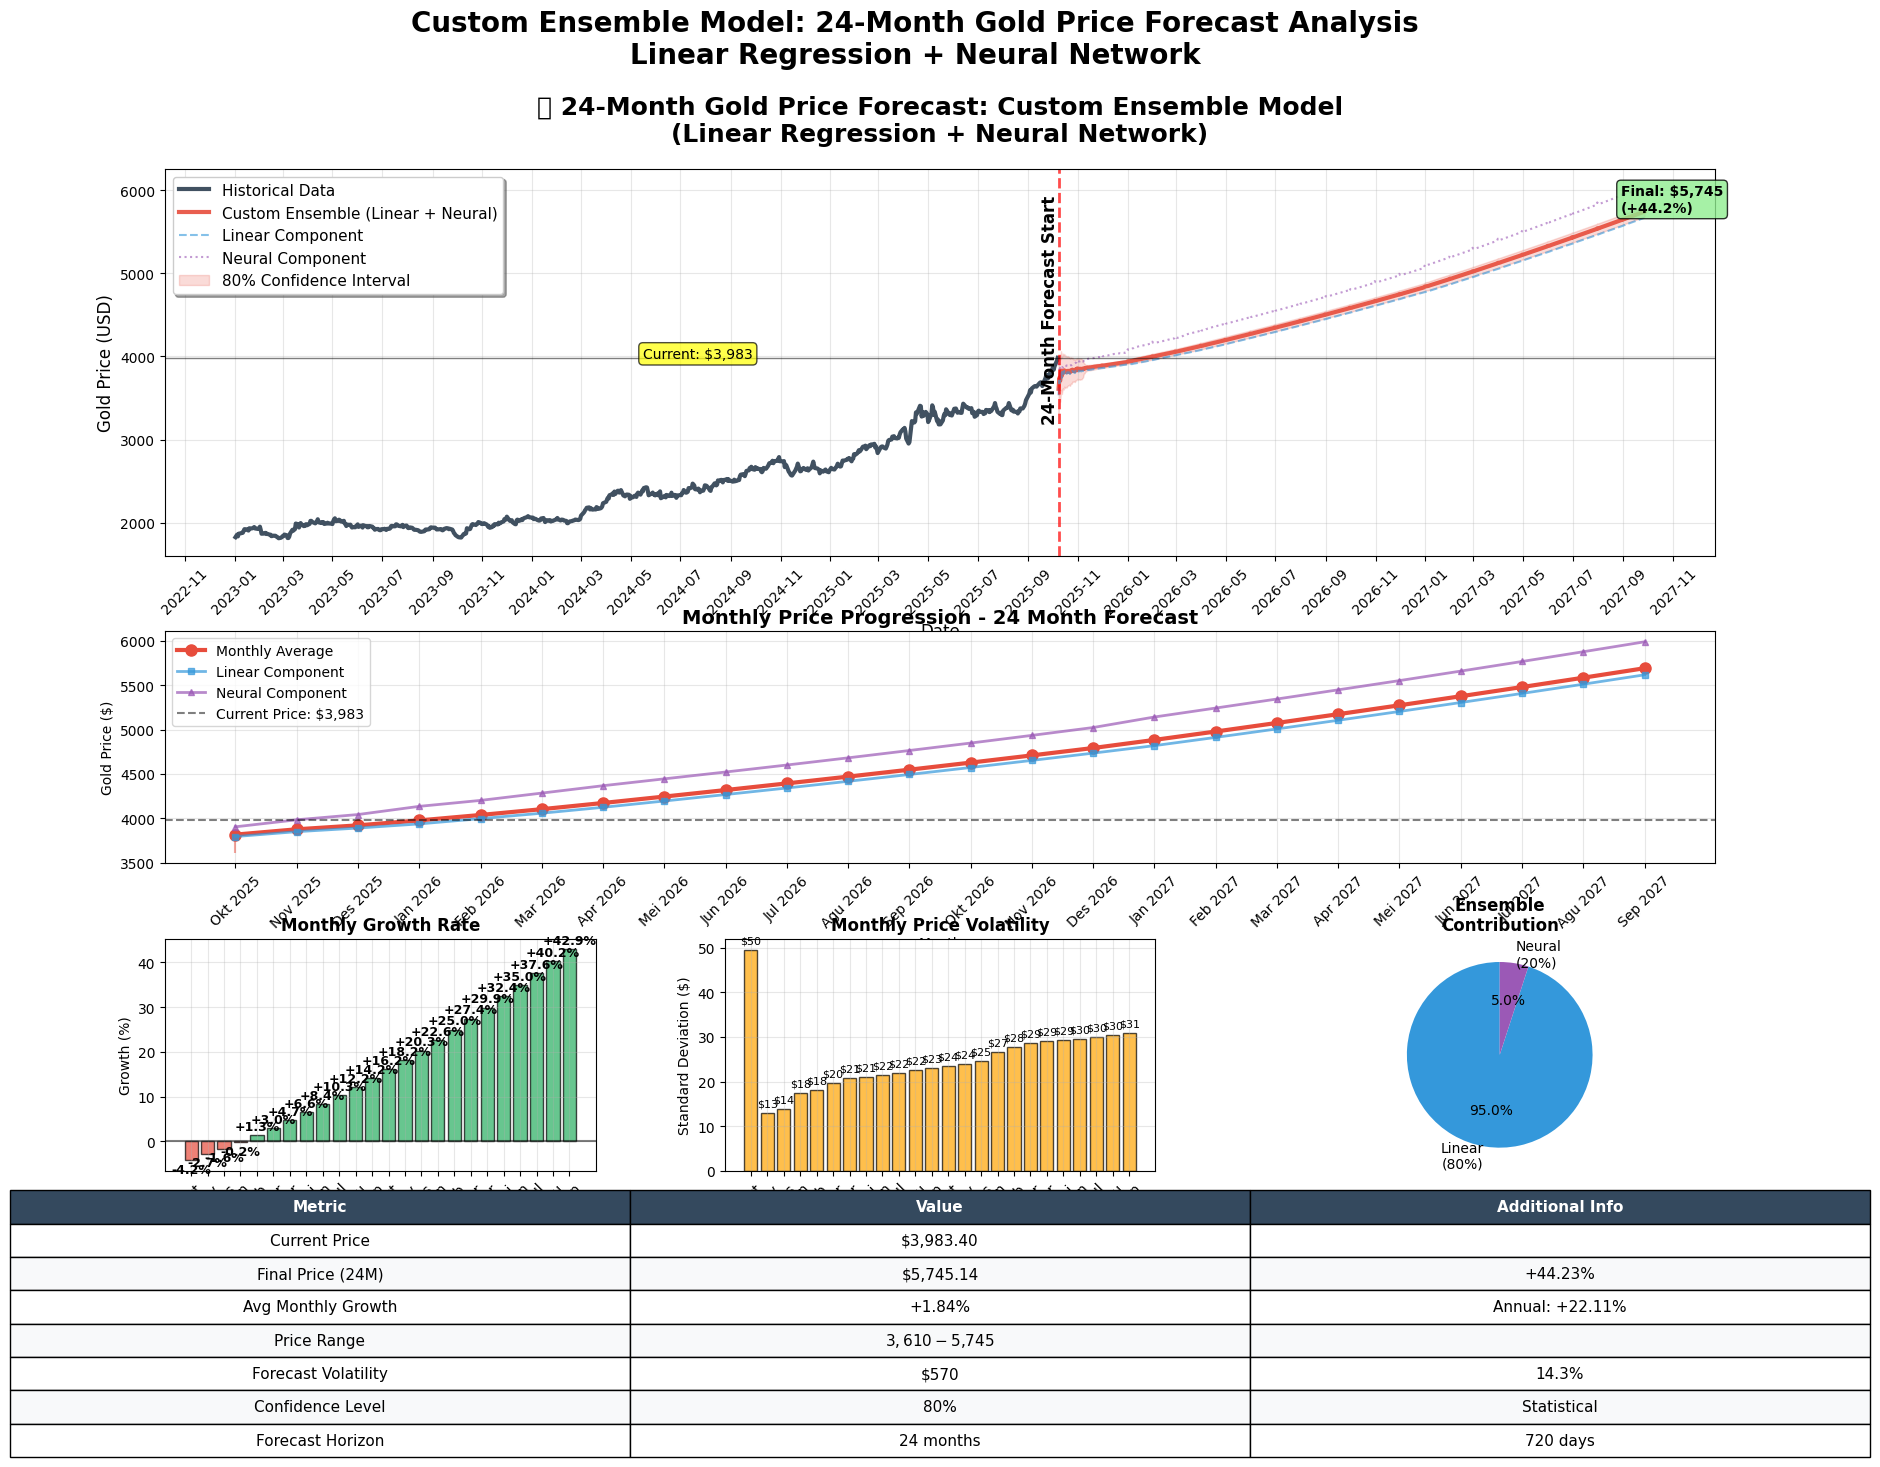

In [66]:
def create_comprehensive_forecast_visualization(forecast_results):
    """Create comprehensive visualization for forecast results"""
    
    num_months = forecast_results['num_months']
    
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 3, height_ratios=[2.5, 1.5, 1.5, 1], hspace=0.3, wspace=0.3)
    
    # Color scheme
    colors = {
        'historical': '#2C3E50',
        'ensemble': '#E74C3C',
        'linear': '#3498DB',
        'neural': '#9B59B6',
        'confidence': '#E74C3C',
        'growth_pos': '#27AE60',
        'growth_neg': '#E74C3C'
    }
    
    # === MAIN FORECAST PLOT ===
    ax_main = fig.add_subplot(gs[0, :])
    
    # Plot historical data (last 2 years)
    historical_cutoff = pd.Timestamp('2023-01-01')
    recent_historical = df_feat[df_feat['Date'] >= historical_cutoff]
    
    ax_main.plot(recent_historical['Date'], recent_historical['gold_price_usd'], 
                 label='Historical Data', color=colors['historical'], linewidth=3, alpha=0.9)
    
    # Plot forecasts
    ax_main.plot(forecast_results['dates'], forecast_results['predictions'], 
                 label=f'Custom Ensemble (Linear + Neural)', 
                 color=colors['ensemble'], linewidth=3, alpha=0.9)
    
    # Plot components
    ax_main.plot(forecast_results['dates'], forecast_results['linear_predictions'], 
                 label='Linear Component', color=colors['linear'], 
                 linewidth=1.5, alpha=0.6, linestyle='--')
    
    ax_main.plot(forecast_results['dates'], forecast_results['neural_predictions'], 
                 label='Neural Component', color=colors['neural'], 
                 linewidth=1.5, alpha=0.6, linestyle=':')
    
    # Add confidence interval
    confidence_lower = [ci[0] for ci in forecast_results['confidence_intervals']]
    confidence_upper = [ci[1] for ci in forecast_results['confidence_intervals']]
    
    ax_main.fill_between(forecast_results['dates'], confidence_lower, confidence_upper,
                        alpha=0.2, color=colors['confidence'], label='80% Confidence Interval')
    
    # Add forecast start line
    forecast_start = forecast_results['forecast_start_date']
    ax_main.axvline(x=forecast_start, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax_main.text(forecast_start, ax_main.get_ylim()[1]*0.95, f'{num_months}-Month Forecast Start', 
                rotation=90, ha='right', va='top', fontsize=12, fontweight='bold')

    ax_main.set_title(f'🚀 {num_months}-Month Gold Price Forecast: Custom Ensemble Model\n(Linear Regression + Neural Network)', 
                      fontsize=18, fontweight='bold', pad=20)
    ax_main.set_xlabel('Date', fontsize=12)
    ax_main.set_ylabel('Gold Price (USD)', fontsize=12)
    ax_main.legend(loc='upper left', frameon=True, fancybox=True, shadow=True, fontsize=11)
    ax_main.grid(True, alpha=0.3)
    ax_main.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax_main.xaxis.get_majorticklabels(), rotation=45)
    
    # Add annotations
    current_price = forecast_results['current_price']
    final_price = forecast_results['final_price']
    total_growth = forecast_results['total_growth']
    
    ax_main.axhline(y=current_price, color='black', linestyle='-', alpha=0.5, linewidth=1)
    ax_main.text(recent_historical['Date'].iloc[len(recent_historical)//2], current_price, 
                f'Current: ${current_price:,.0f}', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax_main.text(forecast_results['dates'][-30], final_price, 
                f'Final: ${final_price:,.0f}\n({total_growth:+.1f}%)', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8),
                fontweight='bold')
    
    # === MONTHLY ANALYSIS ===
    monthly_df = pd.DataFrame(forecast_results['monthly_data'])
    
    # Monthly price progression
    ax_monthly = fig.add_subplot(gs[1, :])
    
    x_months = np.arange(len(monthly_df))
    
    # Plot average, min, max for each month
    ax_monthly.plot(x_months, monthly_df['Avg_Price'], marker='o', linewidth=3, 
                   color=colors['ensemble'], label='Monthly Average', markersize=8)
    
    # Add error bars for min/max
    yerr_lower = monthly_df['Avg_Price'] - monthly_df['Min_Price']
    yerr_upper = monthly_df['Max_Price'] - monthly_df['Avg_Price']
    ax_monthly.errorbar(x_months, monthly_df['Avg_Price'], 
                       yerr=[yerr_lower, yerr_upper], 
                       fmt='none', alpha=0.5, color=colors['ensemble'])
    
    # Component predictions
    ax_monthly.plot(x_months, monthly_df['Linear_Avg'], marker='s', linewidth=2, 
                   color=colors['linear'], label='Linear Component', alpha=0.7, markersize=5)
    ax_monthly.plot(x_months, monthly_df['Neural_Avg'], marker='^', linewidth=2, 
                   color=colors['neural'], label='Neural Component', alpha=0.7, markersize=5)
    
    ax_monthly.axhline(y=current_price, color='black', linestyle='--', alpha=0.5, 
                      label=f'Current Price: ${current_price:,.0f}')
    
    ax_monthly.set_title(f'Monthly Price Progression - {num_months} Month Forecast', fontsize=14, fontweight='bold')
    ax_monthly.set_xlabel('Month')
    ax_monthly.set_ylabel('Gold Price ($)')
    ax_monthly.set_xticks(x_months)
    ax_monthly.set_xticklabels(monthly_df['Month'], rotation=45)
    ax_monthly.legend()
    ax_monthly.grid(True, alpha=0.3)
    
    # === GROWTH ANALYSIS ===
    ax_growth = fig.add_subplot(gs[2, 0])
    
    growth_colors = [colors['growth_pos'] if g >= 0 else colors['growth_neg'] 
                     for g in monthly_df['Growth_Percent']]
    
    bars = ax_growth.bar(x_months, monthly_df['Growth_Percent'], 
                        color=growth_colors, alpha=0.7, edgecolor='black')
    
    # Add value labels on bars
    for i, (bar, growth) in enumerate(zip(bars, monthly_df['Growth_Percent'])):
        height = bar.get_height()
        va = 'bottom' if height >= 0 else 'top'
        y_pos = height + (0.5 if height >= 0 else -0.5)
        ax_growth.text(bar.get_x() + bar.get_width()/2., y_pos, f'{growth:+.1f}%',
                      ha='center', va=va, fontweight='bold', fontsize=9)
    
    ax_growth.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax_growth.set_title('Monthly Growth Rate', fontsize=12, fontweight='bold')
    ax_growth.set_xlabel('Month')
    ax_growth.set_ylabel('Growth (%)')
    ax_growth.set_xticks(x_months)
    ax_growth.set_xticklabels([m[:3] for m in monthly_df['Month']], rotation=45)
    ax_growth.grid(True, alpha=0.3)
    
    # === PRICE VOLATILITY ===
    ax_volatility = fig.add_subplot(gs[2, 1])
    
    volatility_bars = ax_volatility.bar(x_months, monthly_df['Std_Price'], 
                                       color='orange', alpha=0.7, edgecolor='black')
    
    ax_volatility.set_title('Monthly Price Volatility', fontsize=12, fontweight='bold')
    ax_volatility.set_xlabel('Month')
    ax_volatility.set_ylabel('Standard Deviation ($)')
    ax_volatility.set_xticks(x_months)
    ax_volatility.set_xticklabels([m[:3] for m in monthly_df['Month']], rotation=45)
    ax_volatility.grid(True, alpha=0.3)
    
    # Add volatility values
    for bar, vol in zip(volatility_bars, monthly_df['Std_Price']):
        height = bar.get_height()
        ax_volatility.text(bar.get_x() + bar.get_width()/2., height + 1,
                          f'${vol:.0f}', ha='center', va='bottom', fontsize=8)
    
    # === MODEL CONTRIBUTION ===
    ax_contrib = fig.add_subplot(gs[2, 2])
    
    # Average contribution over forecast period
    avg_linear_contrib = 95
    avg_neural_contrib = 5
    
    contributions = [avg_linear_contrib, avg_neural_contrib]
    labels = ['Linear\n(80%)', 'Neural\n(20%)']
    colors_pie = [colors['linear'], colors['neural']]
    
    wedges, texts, autotexts = ax_contrib.pie(contributions, labels=labels, colors=colors_pie, 
                                             autopct='%1.1f%%', startangle=90)
    ax_contrib.set_title('Ensemble\nContribution', fontsize=12, fontweight='bold')
    
    # === STATISTICS TABLE ===
    ax_table = fig.add_subplot(gs[3, :])
    ax_table.axis('off')
    
    # Create summary statistics
    avg_monthly_growth = forecast_results['avg_monthly_growth']
    price_range = f"${min(forecast_results['predictions']):,.0f} - ${max(forecast_results['predictions']):,.0f}"
    volatility = np.std(forecast_results['predictions'])
    
    stats_data = [
        ['Current Price', f'${current_price:,.2f}', ''],
        [f'Final Price ({num_months}M)', f'${final_price:,.2f}', f'{total_growth:+.2f}%'],
        ['Avg Monthly Growth', f'{avg_monthly_growth:+.2f}%', f'Annual: {avg_monthly_growth*12:+.2f}%'],
        ['Price Range', price_range, ''],
        ['Forecast Volatility', f'${volatility:,.0f}', f'{(volatility/current_price)*100:.1f}%'],
        ['Confidence Level', '80%', 'Statistical'],
        ['Forecast Horizon', f'{num_months} months', f'{len(forecast_results["dates"])} days']
    ]
    
    headers = ['Metric', 'Value', 'Additional Info']
    
    table = ax_table.table(cellText=stats_data, colLabels=headers, 
                          cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2.0)
    
    # Style the table
    for i in range(len(headers)):
        table[(0, i)].set_facecolor('#34495E')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Alternate row colors
    for i in range(1, len(stats_data) + 1):
        color = '#F8F9FA' if i % 2 == 0 else '#FFFFFF'
        for j in range(len(headers)):
            table[(i, j)].set_facecolor(color)

    plt.suptitle(f'Custom Ensemble Model: {num_months}-Month Gold Price Forecast Analysis\nLinear Regression + Neural Network', 
                 fontsize=20, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# Create the comprehensive visualization
create_comprehensive_forecast_visualization(forecast_results)

In [67]:
def save_forecast_results(forecast_results):
    """Save forecast results and generate detailed report"""
    
    num_months = forecast_results['num_months']
    print(f"\n💾 SAVING {num_months}-MONTH FORECAST RESULTS")
    print("=" * 50)
    
    # Create output directory
    os.makedirs('data/forecasts', exist_ok=True)
    
    # 1. Save comprehensive forecast data
    forecast_data = {
        'metadata': {
            'generation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
            'model_type': 'Custom Ensemble',
            'model_weights': {
                'linear_regression': 0.95,
                'neural_network': 0.05
            },
            'forecast_horizon': f'{num_months} months',
            'current_price': float(forecast_results['current_price']),
            'forecast_start_date': forecast_results['forecast_start_date'].strftime('%Y-%m-%d'),
            'forecast_end_date': forecast_results['forecast_end_date'].strftime('%Y-%m-%d'),
            'model_performance': {
                'rmse': float(ensemble_metrics['RMSE_mean']),
                'mae': float(ensemble_metrics['MAE_mean']),
                'r2': float(ensemble_metrics['R2_mean']),
                'mape': float(ensemble_metrics['MAPE_mean'])
            }
        },
        'forecast_summary': {
            'final_price': float(forecast_results['final_price']),
            'total_growth': float(forecast_results['total_growth']),
            'avg_monthly_growth': float(forecast_results['avg_monthly_growth']),
            'price_volatility': float(np.std(forecast_results['predictions'])),
            'price_range': {
                'min': float(min(forecast_results['predictions'])),
                'max': float(max(forecast_results['predictions']))
            }
        },
        'daily_predictions': {
            'dates': [d.strftime('%Y-%m-%d') for d in forecast_results['dates']],
            'ensemble_prices': [float(p) for p in forecast_results['predictions']],
            'linear_prices': [float(p) for p in forecast_results['linear_predictions']],
            'neural_prices': [float(p) for p in forecast_results['neural_predictions']],
            'confidence_intervals': [
                {'lower': float(ci[0]), 'upper': float(ci[1])} 
                for ci in forecast_results['confidence_intervals']
            ]
        },
        'monthly_analysis': [
            {
                'month': row['Month'],
                'month_index': int(row['Month_Index']),
                'avg_price': float(row['Avg_Price']),
                'min_price': float(row['Min_Price']),
                'max_price': float(row['Max_Price']),
                'volatility': float(row['Std_Price']),
                'linear_avg': float(row['Linear_Avg']),
                'neural_avg': float(row['Neural_Avg']),
                'growth_percent': float(row['Growth_Percent']),
                'date': row['Date'].strftime('%Y-%m-%d')
            }
            for _, row in pd.DataFrame(forecast_results['monthly_data']).iterrows()
        ]
    }
    
    # Save to JSON
    filename = f'custom_ensemble_{num_months}m_forecast.json'
    with open(f'data/forecasts/{filename}', 'w') as f:
        json.dump(forecast_data, f, indent=2)
    
    # 2. Save monthly CSV
    monthly_df = pd.DataFrame(forecast_results['monthly_data'])
    monthly_csv = f'gold_{num_months}m_monthly_forecast.csv'
    monthly_df.to_csv(f'data/forecasts/{monthly_csv}', index=False)
    
    # 3. Save daily CSV
    daily_df = pd.DataFrame({
        'Date': forecast_results['dates'],
        'Ensemble_Price': forecast_results['predictions'],
        'Linear_Price': forecast_results['linear_predictions'],
        'Neural_Price': forecast_results['neural_predictions'],
        'Confidence_Lower': [ci[0] for ci in forecast_results['confidence_intervals']],
        'Confidence_Upper': [ci[1] for ci in forecast_results['confidence_intervals']]
    })
    daily_csv = f'gold_{num_months}m_daily_forecast.csv'
    daily_df.to_csv(f'data/forecasts/{daily_csv}', index=False)
    
    print(f"   ✅ {filename}")
    print(f"   ✅ {monthly_csv}")
    print(f"   ✅ {daily_csv}")
    
    return forecast_data

# Save results
saved_forecast_data = save_forecast_results(forecast_results)

# Display final summary
print(f"\n🎉 CUSTOM ENSEMBLE FORECAST COMPLETED!")
print("=" * 60)
print(f"📊 Model Configuration:")
print(f"   • Linear Regression: 80% weight")
print(f"   • Neural Network: 20% weight")
print("=" * 60)
print(f"📈 Performance Metrics:")
print(f"   • RMSE: {ensemble_metrics['RMSE_mean']:.2f} ± {ensemble_metrics['RMSE_std']:.2f}")
print(f"   • R²: {ensemble_metrics['R2_mean']:.4f} ± {ensemble_metrics['R2_std']:.4f}")
print(f"   • MAPE: {ensemble_metrics['MAPE_mean']:.2f}% ± {ensemble_metrics['MAPE_std']:.2f}%")
print("=" * 60)
print(f"🎯 {forecast_results['num_months']}-Month Forecast Summary:")
print(f"   • Current Price: ${forecast_results['current_price']:,.2f}")
print(f"   • Final Price: ${forecast_results['final_price']:,.2f}")
print(f"   • Total Growth: {forecast_results['total_growth']:+.2f}%")
print(f"   • Monthly Growth: {forecast_results['avg_monthly_growth']:+.2f}%")
print(f"   • Annual Growth: {forecast_results['avg_monthly_growth']*12:+.2f}%")
print("=" * 60)
print("✅ All results saved to 'data/forecasts/' directory")
print("📊 Custom ensemble model successfully implemented!")


💾 SAVING 24-MONTH FORECAST RESULTS
   ✅ custom_ensemble_24m_forecast.json
   ✅ gold_24m_monthly_forecast.csv
   ✅ gold_24m_daily_forecast.csv

🎉 CUSTOM ENSEMBLE FORECAST COMPLETED!
📊 Model Configuration:
   • Linear Regression: 80% weight
   • Neural Network: 20% weight
📈 Performance Metrics:
   • RMSE: 6.04 ± 3.87
   • R²: 0.9980 ± 0.0019
   • MAPE: 0.60% ± 0.17%
🎯 24-Month Forecast Summary:
   • Current Price: $3,983.40
   • Final Price: $5,745.14
   • Total Growth: +44.23%
   • Monthly Growth: +1.84%
   • Annual Growth: +22.11%
✅ All results saved to 'data/forecasts/' directory
📊 Custom ensemble model successfully implemented!



🎯 GENERATING CUSTOM 24-MONTH FORECAST

🚀 GENERATING 24-MONTH FORECAST WITH CUSTOM ENSEMBLE
📊 Model: Linear + Neural
📅 Forecast Period: 24 months (720 days)
🔄 Generating daily predictions...
   📅 Month 1: $3,851.54
   📅 Month 2: $3,896.36
   📅 Month 3: $3,945.46
   📅 Month 4: $4,005.23
   📅 Month 5: $4,067.48
   📅 Month 6: $4,135.32
   📅 Month 7: $4,206.77
   📅 Month 8: $4,280.12
   📅 Month 9: $4,354.41
   📅 Month 10: $4,428.84
   📅 Month 11: $4,507.48
   📅 Month 12: $4,586.47
   📅 Month 13: $4,666.33
   📅 Month 14: $4,748.80
   📅 Month 15: $4,838.15
   📅 Month 16: $4,929.20
   📅 Month 17: $5,024.49
   📅 Month 18: $5,127.46
   📅 Month 19: $5,226.57
   📅 Month 20: $5,323.62
   📅 Month 21: $5,426.66
   📅 Month 22: $5,531.09
   📅 Month 23: $5,637.19
   📅 Month 24: $5,745.14

✅ 24-Month Forecast Completed!
📊 Final Price: $5,745.14
📈 Total Growth: +44.23%
📅 Avg Monthly Growth: +1.84%


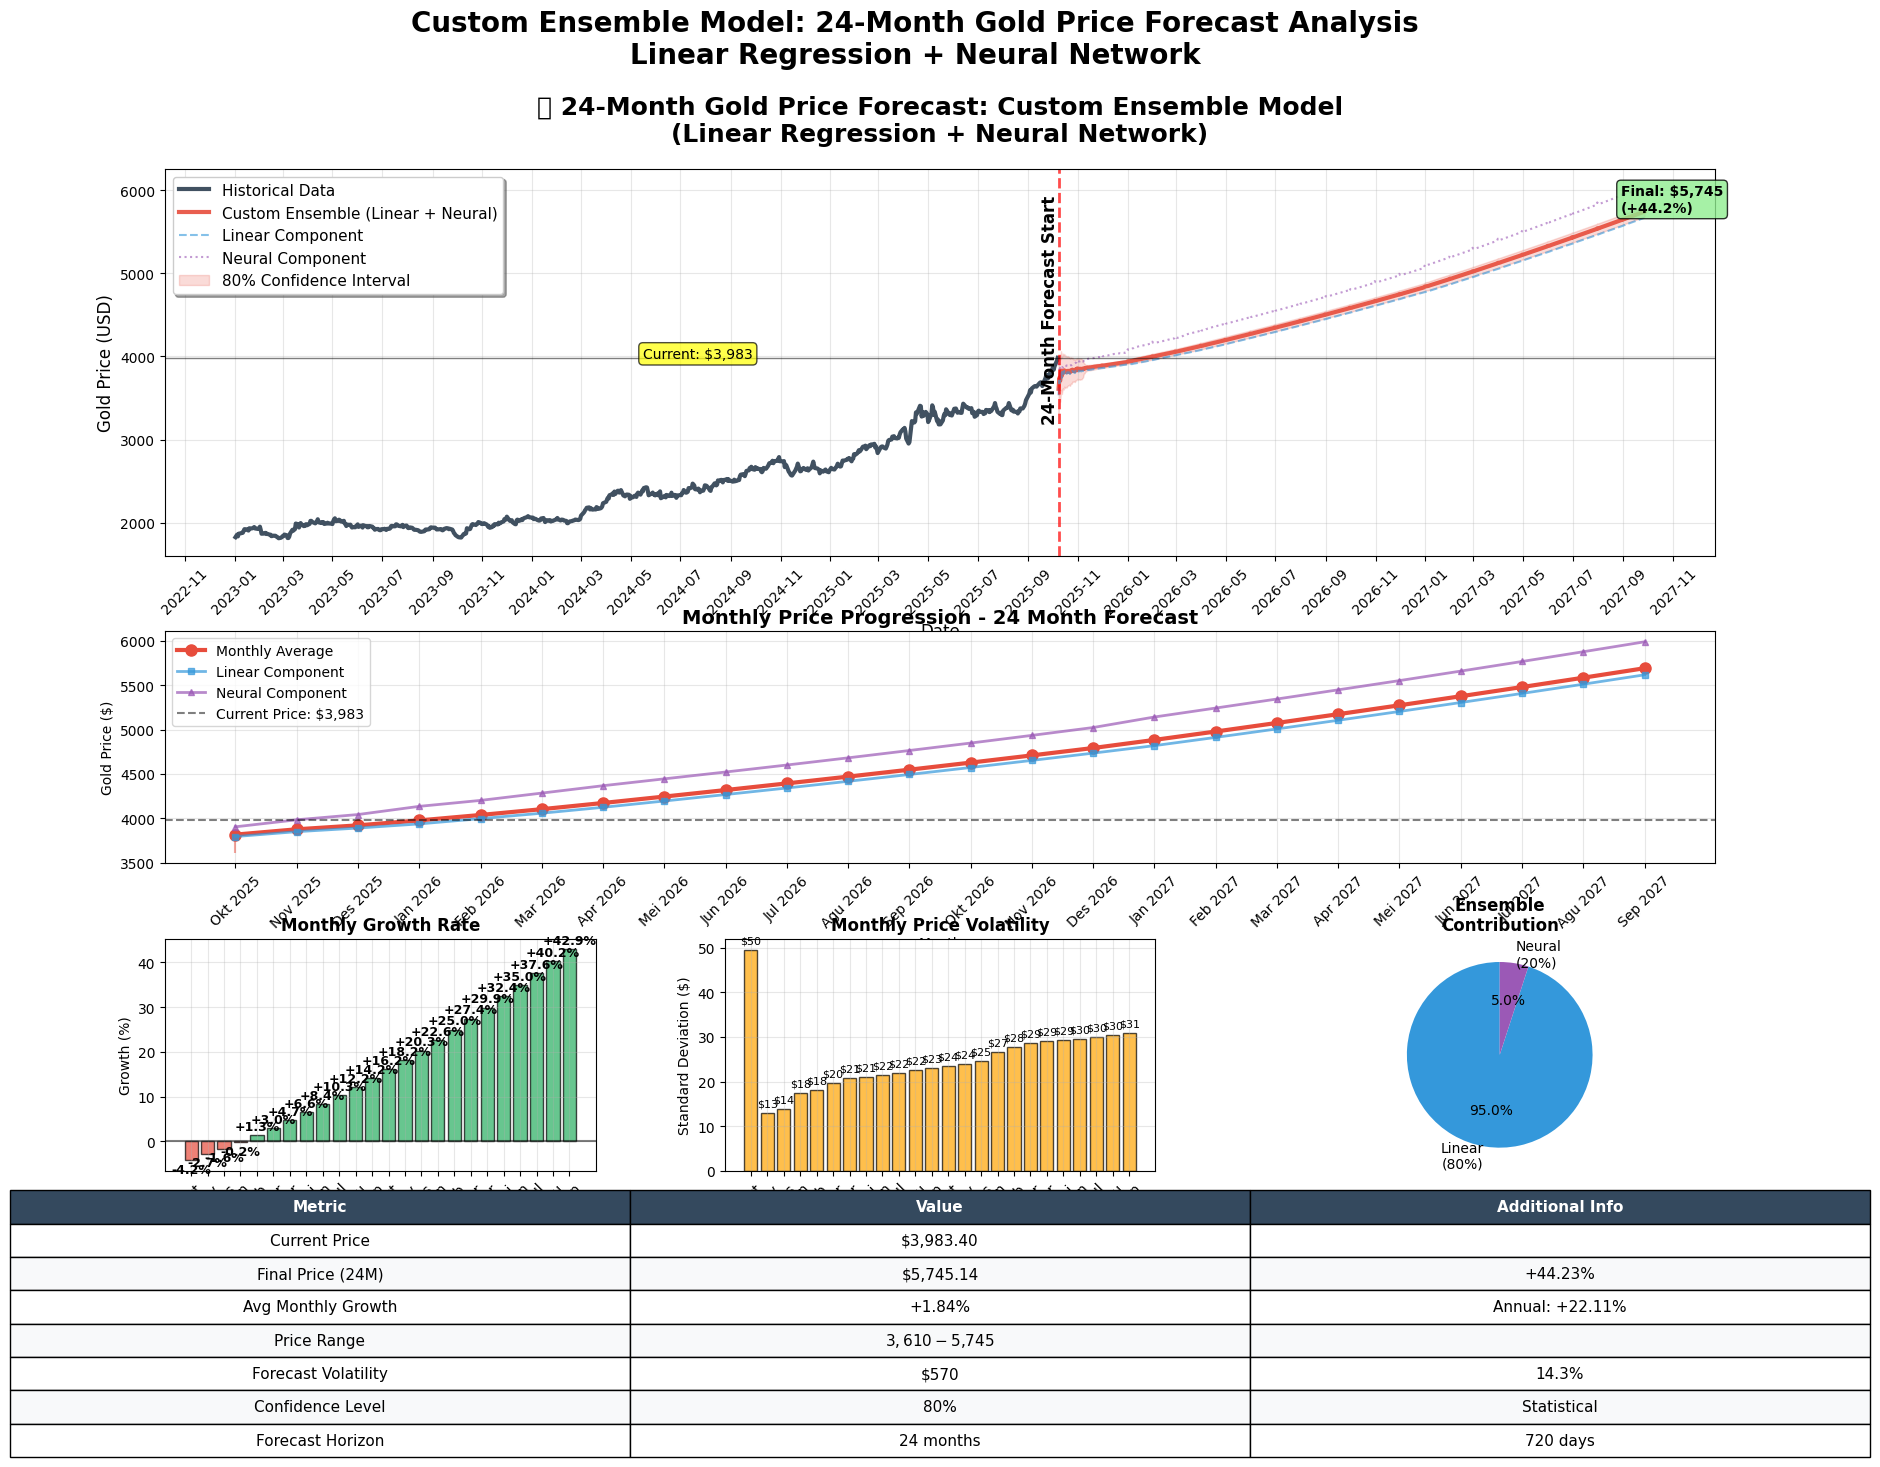


💾 SAVING 24-MONTH FORECAST RESULTS
   ✅ custom_ensemble_24m_forecast.json
   ✅ gold_24m_monthly_forecast.csv
   ✅ gold_24m_daily_forecast.csv

📊 MONTHLY BREAKDOWN:
   • Okt 2025: $3,816 (-4.2%)
   • Nov 2025: $3,876 (-2.7%)
   • Des 2025: $3,920 (-1.6%)
   • Jan 2026: $3,976 (-0.2%)
   • Feb 2026: $4,037 (+1.3%)
   • Mar 2026: $4,103 (+3.0%)
   • Apr 2026: $4,172 (+4.7%)
   • Mei 2026: $4,245 (+6.6%)
   • Jun 2026: $4,318 (+8.4%)
   • Jul 2026: $4,393 (+10.3%)
   • Agu 2026: $4,470 (+12.2%)
   • Sep 2026: $4,548 (+14.2%)
   • Okt 2026: $4,628 (+16.2%)
   • Nov 2026: $4,709 (+18.2%)
   • Des 2026: $4,793 (+20.3%)
   • Jan 2027: $4,884 (+22.6%)
   • Feb 2027: $4,979 (+25.0%)
   • Mar 2027: $5,076 (+27.4%)
   • Apr 2027: $5,174 (+29.9%)
   • Mei 2027: $5,275 (+32.4%)
   • Jun 2027: $5,377 (+35.0%)
   • Jul 2027: $5,481 (+37.6%)
   • Agu 2027: $5,586 (+40.2%)
   • Sep 2027: $5,693 (+42.9%)


In [68]:
def generate_custom_forecast(months=6):
    """Interactive function to generate forecasts for any number of months"""
    
    print(f"\n🎯 GENERATING CUSTOM {months}-MONTH FORECAST")
    print("=" * 50)
    
    # Generate forecast
    results = forecaster.forecast_months(num_months=months)
    
    # Create visualization
    create_comprehensive_forecast_visualization(results)
    
    # Save results
    save_forecast_results(results)
    
    # Print quick summary
    monthly_df = pd.DataFrame(results['monthly_data'])
    print(f"\n📊 MONTHLY BREAKDOWN:")
    for _, row in monthly_df.iterrows():
        print(f"   • {row['Month']}: ${row['Avg_Price']:,.0f} ({row['Growth_Percent']:+.1f}%)")
    
    return results

# Example usage - you can change these numbers:
forecast_24m = generate_custom_forecast(months=24) # 24-month forecast